In [33]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

## Calculating Wind Veer and Shear

In [36]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    return diff

def calculate_power_law_exponent(v1, v2, z1, z2):
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)


### Wind Veer Plotting 

In [39]:
def plot_wind_veer(times, wind_veer):
    """
    Plot wind veer over time.
    
    Parameters:
        times (list): List of datetime objects.
        wind_veer (list): List of wind veer values.
    """
    # Debugging: Check the data before plotting
    if len(times) == 0 or len(wind_veer) == 0:
        print("Error: No data to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(times, wind_veer, label="Wind Veer (140m - 40m)", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Wind Veer (m/s)")
    plt.title("Wind Veer Over Time")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

## File Collection

In [42]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        # CHANGEME below is for site A2
        #if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site C1A
        if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]

# CHANGEME Usage for Site A2
#directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteA2'
# CHANGEME Usage for Site C1a
directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'

start_date = '20221111'  # Replace with any start date
end_date = '20231106'    # Replace with any end date

matching_files = filter_files_by_date(directory, start_date, end_date)
#print("Matching files:")
#for file_path in matching_files:
#    print(file_path)

Using Lidar Location: (Lat: 36.36, Lon: -97.51)
Using Roughness z0: 0.1
Using Turbine DB: /Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/uswtdb_V8_1_20250522.csv
Wake Influence Zone: 20 Rotor Diameters
Loaded 76051 turbines from CSV, 5597 in OK.
Calculating turbine geometry relative to Lidar...
Found 7 turbines within 20D of the Lidar.
Plotting map with 7 relevant and 5590 non-relevant turbines.
Saved turbine map to 'c1a_turbine_map.png'


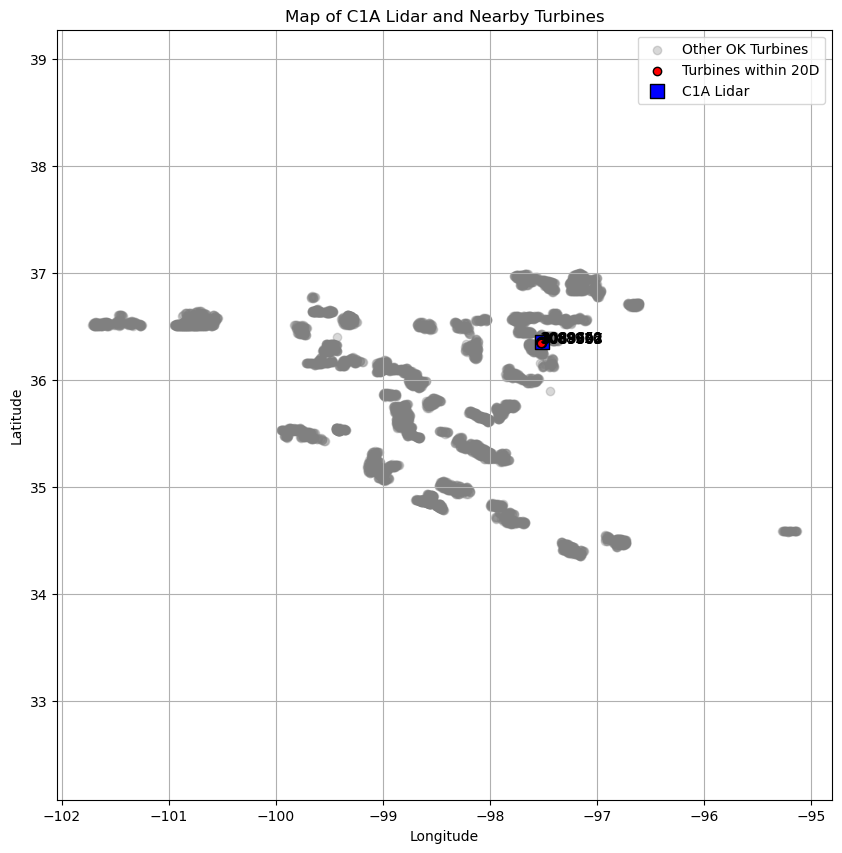

Loading Lidar data from 373 files...
Data loading complete.
Successfully loaded 237614 QC-passed Lidar records.
Flagging contaminated data...
Flagged 65497 records (27.56%) as wake-contaminated.
Generating monthly data availability plot...
Saved data availability plot to 'c1a_monthly_data_availability.png'


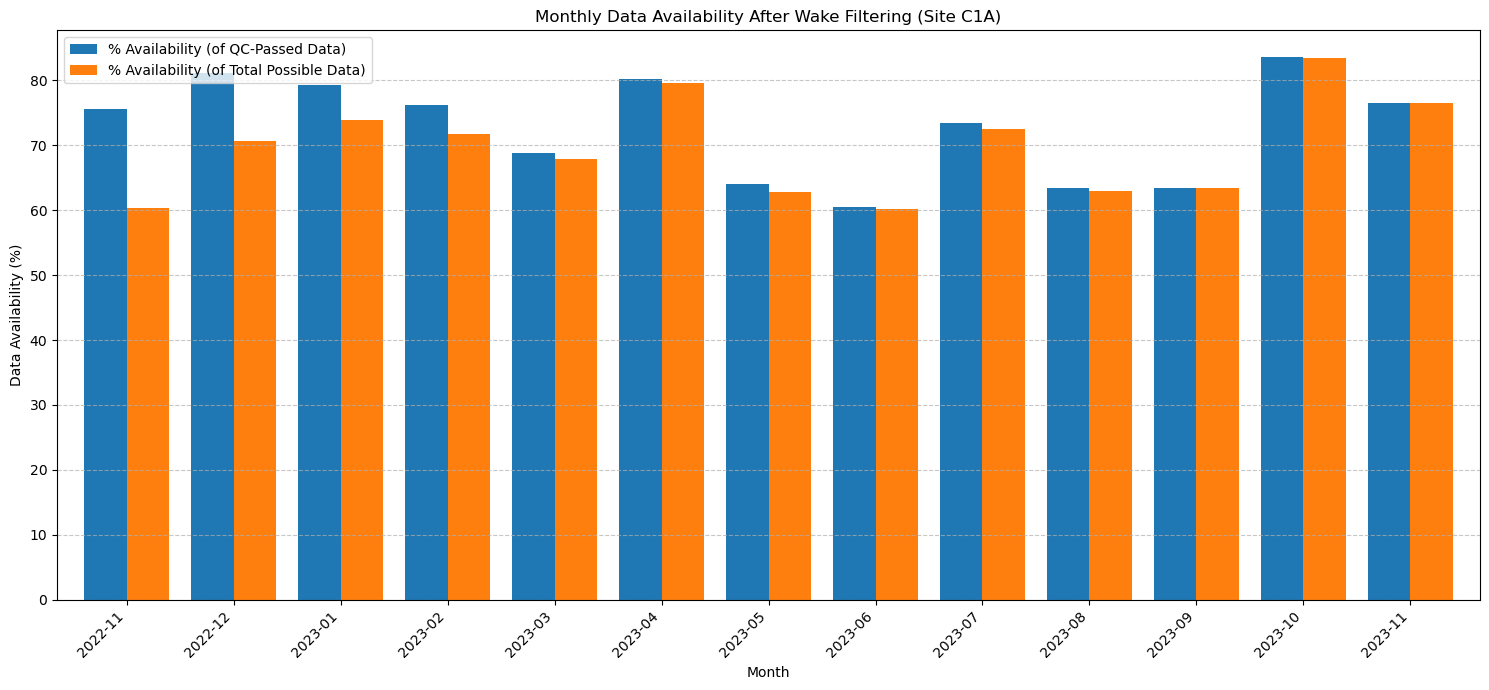


Analysis complete.
Saved uncontaminated data to 'c1a_final_uncontaminated_data.csv'


In [44]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from datetime import datetime, timedelta

# --- 1. Define Lidar Location and Constants ---
LIDAR_LAT = 36.36  # Placeholder Latitude
LIDAR_LON = -97.51 # Placeholder Longitude

Z0_ROUGHNESS = 0.1 # Roughness length (z0)
TURBINE_CSV_PATH = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/uswtdb_V8_1_20250522.csv'
WAKE_INFLUENCE_DISTANCE_D = 20 # 20D wake influence zone

print(f"Using Lidar Location: (Lat: {LIDAR_LAT}, Lon: {LIDAR_LON})")
print(f"Using Roughness z0: {Z0_ROUGHNESS}")
print(f"Using Turbine DB: {TURBINE_CSV_PATH}")
print(f"Wake Influence Zone: {WAKE_INFLUENCE_DISTANCE_D} Rotor Diameters")

# --- 2. Geometric Helper Functions ---

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth (specified in decimal degrees) in meters.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371000 # Radius of Earth in meters
    return c * r

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the initial bearing (angle) from point 1 to point 2
    in degrees (0-360, clockwise from North).
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1

    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    
    bearing = np.degrees(np.arctan2(y, x))
    bearing = (bearing + 360) % 360
    return bearing

def is_direction_contaminated(direction, ranges):
    """
    Checks if a wind direction is within any of the problematic ranges.
    Handles 0/360 degree wraparound.
    """
    for r_min, r_max in ranges:
        if r_min <= r_max:
            # Standard case (e.g., 270 to 290)
            if r_min <= direction <= r_max:
                return True
        else:
            # Wraparound case (e.g., 350 to 10)
            if direction >= r_min or direction <= r_max:
                return True
    return False

# --- 3. New Data Loading Function ---
# This function replaces 'calculate_wind_veer' and 'calculate_wind_shear_with_alpha'
# It processes the netCDF files ONCE and returns a single, complete DataFrame.

def wind_direction_difference(dir1, dir2):
    """Calculates the shortest angle difference, handling wraparound."""
    diff = dir2 - dir1
    return (diff + 180) % 360 - 180

def calculate_power_law_exponent(v1, v2, z1, z2):
    """Calculates the power law exponent 'alpha'."""
    # Ensure no log(0) or division by zero
    v1 = np.where(v1 <= 0, 0.01, v1)
    v2 = np.where(v2 <= 0, 0.01, v2)
    return np.log(v2 / v1) / np.log(z2 / z1)

def load_lidar_data(file_paths, start_date=None, end_date=None):
    """
    Loads all required Lidar data from netCDF files, applies QC,
    calculates shear/veer, and returns a single pandas DataFrame.
    """
    all_times = []
    all_dir_40m = []
    all_dir_140m = []
    all_veer = []
    all_shear = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    print(f"Loading Lidar data from {len(file_paths)} files...")
    for file_path in file_paths:
        try:
            ds = xr.open_dataset(file_path)
            
            # Extract data
            time_var = ds['time']
            height_var = ds['height'].values
            vhm = ds['Vhm'].values
            qc_vhm = ds['qc_Vhm'].values
            azim = ds['Azim'].values
            qc_azim = ds['qc_Azim'].values
            
            times = pd.to_datetime(time_var.values, utc=True)
            
            # Filter by date range
            valid_idx = (times >= start_date) & (times <= end_date)
            if not np.any(valid_idx):
                ds.close()
                continue

            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
            azim = azim[valid_idx, :]
            qc_azim = qc_azim[valid_idx, :]

            # Get height indices
            try:
                idx_40m = np.where(height_var == 40)[0][0]
                idx_140m = np.where(height_var == 140)[0][0]
            except IndexError:
                print(f"Warning: 40m or 140m not in {file_path}. Skipping.")
                ds.close()
                continue
            
            # Get raw directions and speeds
            wind_direction_40m = azim[:, idx_40m]
            wind_direction_140m = azim[:, idx_140m]
            wind_speed_40m = vhm[:, idx_40m]
            wind_speed_140m = vhm[:, idx_140m]
            
            # Calculate Veer (from your notebook)
            height_diff = height_var[idx_140m] - height_var[idx_40m]
            veer_diff = wind_direction_difference(wind_direction_40m, wind_direction_140m)
            wind_veer = veer_diff / height_diff
            
            # Calculate Shear (from your notebook)
            wind_shear = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
            
            # Apply QC mask (from your notebook)
            valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & \
                         (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0) & \
                         (wind_speed_40m > 0) & (wind_speed_140m > 0) # Added positive speed check for shear calc
            
            # Append valid data
            all_times.extend(times[valid_mask])
            all_dir_40m.extend(wind_direction_40m[valid_mask])
            all_dir_140m.extend(wind_direction_140m[valid_mask])
            all_veer.extend(wind_veer[valid_mask])
            all_shear.extend(wind_shear[valid_mask])
            
            ds.close()
            
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue

    print("Data loading complete.")
    
    # Create final DataFrame
    df_lidar = pd.DataFrame({
        'time': all_times,
        'wind_direction_40m': all_dir_40m,
        'wind_direction_140m': all_dir_140m,
        'veer_lidar': all_veer,
        'shear_lidar': all_shear
    })
    
    # Sort by time just in case files were out of order
    df_lidar = df_lidar.sort_values(by='time').reset_index(drop=True)
    
    return df_lidar

# --- 4. Main Analysis Script ---

# Load Turbine Data
try:
    df_turbines = pd.read_csv(TURBINE_CSV_PATH)
    # Filter to OK to speed up processing
    df_turbines_ok = df_turbines[df_turbines['t_state'] == 'OK'].copy()
    print(f"Loaded {len(df_turbines)} turbines from CSV, {len(df_turbines_ok)} in OK.")
except Exception as e:
    print(f"Error: Could not load turbine CSV file. {e}")
    # Create empty df as fallback
    df_turbines_ok = pd.DataFrame(columns=['xlong', 'ylat', 't_hh', 't_rd'])


if not df_turbines_ok.empty:
    # --- Step 4a: Map Turbines and C1A (Your Step 1 & 5) ---
    print("Calculating turbine geometry relative to Lidar...")
    df_turbines_ok['distance_m'] = haversine(LIDAR_LAT, LIDAR_LON, df_turbines_ok['ylat'], df_turbines_ok['xlong'])
    
    # Bearing *from* Lidar *to* Turbine
    bearing_to_turbine = calculate_bearing(LIDAR_LAT, LIDAR_LON, df_turbines_ok['ylat'], df_turbines_ok['xlong'])
    
    # Wind direction *from* Turbine *to* Lidar (add 180 and wrap)
    df_turbines_ok['wake_source_direction'] = (bearing_to_turbine + 180) % 360

    # --- Step 4b: Calculate Wake Expansion (Your Step 2 & 7) ---
    # Using Jensen model for wake expansion coefficient 'k'
    df_turbines_ok['k'] = 0.5 / np.log(df_turbines_ok['t_hh'] / Z0_ROUGHNESS)
    
    # Calculate the wake width at the Lidar's distance
    df_turbines_ok['wake_width_m'] = df_turbines_ok['t_rd'] + 2 * df_turbines_ok['k'] * df_turbines_ok['distance_m']
    
    # Calculate the half-angle of the wake cone in degrees
    df_turbines_ok['wake_half_angle_deg'] = np.degrees(np.arctan((df_turbines_ok['wake_width_m'] / 2) / df_turbines_ok['distance_m']))

    # --- Step 4c: Identify Relevant Turbines and Directions (Your Step 3 & 5) ---
    # Filter for turbines within the 20D influence zone
    df_relevant_turbines = df_turbines_ok[df_turbines_ok['distance_m'] <= (WAKE_INFLUENCE_DISTANCE_D * df_turbines_ok['t_rd'])].copy()
    
    print(f"Found {len(df_relevant_turbines)} turbines within {WAKE_INFLUENCE_DISTANCE_D}D of the Lidar.")

    # Create the list of problematic wind direction ranges
    problematic_ranges = []
    for _, row in df_relevant_turbines.iterrows():
        center_dir = row['wake_source_direction']
        half_angle = row['wake_half_angle_deg']
        
        dir_min = (center_dir - half_angle + 360) % 360
        dir_max = (center_dir + half_angle) % 360
        
        problematic_ranges.append((dir_min, dir_max))
        # print(f"Turbine {row['case_id']}: Dist={row['distance_m']:.0f}m, "
        #       f"RotorD={row['t_rd']}m, Angle={center_dir:.1f}°, "
        #       f"Cone=[{dir_min:.1f}°, {dir_max:.1f}°] (Half-width: {half_angle:.1f}°)")

    # --- Step 4d: Plot the Turbine Map (Your Step 1) ---
    
    # NEW: Create a DataFrame of *only* the non-relevant turbines
    # We get the 'case_id' of the relevant turbines
    relevant_ids = df_relevant_turbines['case_id']
    
    # We select all turbines from the 'ok' list whose 'case_id' is NOT in the relevant list
    df_non_relevant_turbines = df_turbines_ok[~df_turbines_ok['case_id'].isin(relevant_ids)]
    
    print(f"Plotting map with {len(df_relevant_turbines)} relevant and {len(df_non_relevant_turbines)} non-relevant turbines.")

    plt.figure(figsize=(10, 10))
    
    # Plot 1: Non-relevant turbines (gray, in the back)
    
    plt.scatter(
        df_non_relevant_turbines['xlong'], 
        df_non_relevant_turbines['ylat'], 
        c='gray', 
        alpha=0.3, 
        label='Other OK Turbines',
        zorder=1  # Back layer
    )

    # Plot 2: Relevant turbines (red, on top)
    plt.scatter(
        df_relevant_turbines['xlong'], 
        df_relevant_turbines['ylat'], 
        c='red', 
        label=f'Turbines within {WAKE_INFLUENCE_DISTANCE_D}D',
        edgecolors='k', # Add a black edge to make them pop
        zorder=3  # Front layer
    )
    
    # Plot 3: Lidar (blue, on top)
    plt.scatter(
        LIDAR_LON, 
        LIDAR_LAT, 
        c='blue', 
        marker='s', 
        s=100, 
        label='C1A Lidar', 
        edgecolors='k',
        zorder=2  # Very front layer
    )
    
    # Annotate relevant turbines
    for _, row in df_relevant_turbines.iterrows():
        plt.text(row['xlong'], row['ylat'], str(row['case_id']), zorder=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Map of C1A Lidar and Nearby Turbines')
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # Equal scaling for lat/lon
    plt.savefig('c1a_turbine_map.png')
    print("Saved turbine map to 'c1a_turbine_map.png'")
    plt.show()

    # --- Step 4e: Load Lidar Data ---
    # We assume 'matching_files', 'start_date', 'end_date' exist from your notebook
    try:
        df_lidar = load_lidar_data(matching_files, start_date, end_date)
        print(f"Successfully loaded {len(df_lidar)} QC-passed Lidar records.")
    except Exception as e:
        print(f"Error: Could not load Lidar data. {e}")
        df_lidar = pd.DataFrame() # empty fallback

    if not df_lidar.empty:
        # --- Step 4f: Flag Contaminated Data (Your Step 4) ---
        print("Flagging contaminated data...")
        df_lidar['contaminated_40m'] = df_lidar['wind_direction_40m'].apply(
            lambda x: is_direction_contaminated(x, problematic_ranges)
        )
        df_lidar['contaminated_140m'] = df_lidar['wind_direction_140m'].apply(
            lambda x: is_direction_contaminated(x, problematic_ranges)
        )
        
        # A record is contaminated if either height is in a wake
        df_lidar['wake_contaminated'] = df_lidar['contaminated_40m'] | df_lidar['contaminated_140m']
        
        contamination_pct = (df_lidar['wake_contaminated'].sum() / len(df_lidar)) * 100
        print(f"Flagged {df_lidar['wake_contaminated'].sum()} records ({contamination_pct:.2f}%) as wake-contaminated.")

        # --- Step 4g: Plot Monthly Data Availability (Your Final Request) ---
        print("Generating monthly data availability plot...")
        
        # We need the *original* number of measurements per month to get a true availability %
        # Let's re-load the data but *only* apply time filter, not QC, to get total possible data
        
        # Simplified load for total counts
        all_times_total = []
        for file_path in matching_files:
            try:
                ds = xr.open_dataset(file_path)
                times = pd.to_datetime(ds['time'].values, utc=True)
                valid_idx = (times >= start_date) & (times <= end_date)
                all_times_total.extend(times[valid_idx])
                ds.close()
            except Exception:
                continue
        
        df_total = pd.DataFrame({'time': all_times_total})
        
        # --- Start of Warning Suppression ---
        # Suppress the UserWarning when converting to PeriodIndex
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            df_total['month_year'] = df_total['time'].dt.to_period('M')
        # --- End of Warning Suppression ---

        total_possible_counts = df_total.groupby('month_year').size()
        
        # Get counts for QC-passed data (this is the baseline for *your* analysis)
        # --- Start of Warning Suppression ---
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            df_lidar['month_year'] = df_lidar['time'].dt.to_period('M')
        # --- End of Warning Suppression ---
            
        total_qc_passed_counts = df_lidar.groupby('month_year').size()

        # Get counts for final, uncontaminated data
        df_uncontaminated = df_lidar[~df_lidar['wake_contaminated']]
        final_uncontaminated_counts = df_uncontaminated.groupby('month_year').size()

        # Calculate percentages
        # % of QC-passed data that is *not* wake-contaminated
        pct_of_qc_passed = (final_uncontaminated_counts / total_qc_passed_counts).fillna(0) * 100
        
        # % of *total possible* data that is final and clean
        pct_of_total = (final_uncontaminated_counts / total_possible_counts).reindex(pct_of_qc_passed.index).fillna(0) * 100

        # Plotting
        fig, ax = plt.subplots(figsize=(15, 7))
        
        # Create a DataFrame for plotting
        df_plot = pd.DataFrame({
            '% Availability (of QC-Passed Data)': pct_of_qc_passed,
            '% Availability (of Total Possible Data)': pct_of_total
        })
        
        df_plot.index = df_plot.index.astype(str) # Convert PeriodIndex to string for plotting
        
        df_plot.plot(kind='bar', ax=ax, width=0.8)
        
        ax.set_title('Monthly Data Availability After Wake Filtering (Site C1A)')
        ax.set_ylabel('Data Availability (%)')
        ax.set_xlabel('Month')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend()
        plt.tight_layout()
        plt.savefig('c1a_monthly_data_availability.png')
        print("Saved data availability plot to 'c1a_monthly_data_availability.png'")
        plt.show()
        
        print("\nAnalysis complete.")
        
        # Optional: Save the final filtered DataFrame
        try:
            csv_filename = 'c1a_final_uncontaminated_data.csv'
            df_uncontaminated.to_csv(csv_filename, index=False)
            print(f"Saved uncontaminated data to '{csv_filename}'")
        except Exception as e:
            print(f"Could not save final CSV: {e}")

In [46]:
print("--- Creating Final DataFrames for Notebook Analysis ---")

# Take our final, clean DataFrame and set 'time' as the index
# This matches the format your original analysis cells expect
df_analysis = df_uncontaminated.set_index('time')

# Re-create the exact 'df_veer' and 'df_shear' variables
# that your downstream plotting cells are looking for.
df_veer = df_analysis[['veer_lidar']].copy()
df_shear = df_analysis[['shear_lidar']].copy()

print(f"Ready for analysis with {len(df_veer)} clean data points.")
print("\ndf_veer.head():")
print(df_veer.head())
print("\ndf_shear.head():")
print(df_shear.head())

--- Creating Final DataFrames for Notebook Analysis ---
Ready for analysis with 172117 clean data points.

df_veer.head():
                           veer_lidar
time                                 
2022-11-11 02:28:00+00:00       0.058
2022-11-11 02:30:00+00:00       0.009
2022-11-11 02:40:00+00:00       0.048
2022-11-11 02:42:00+00:00       0.017
2022-11-11 02:56:00+00:00       0.036

df_shear.head():
                           shear_lidar
time                                  
2022-11-11 02:28:00+00:00     0.277248
2022-11-11 02:30:00+00:00     0.215561
2022-11-11 02:40:00+00:00     0.211452
2022-11-11 02:42:00+00:00     0.126361
2022-11-11 02:56:00+00:00     0.185403


### Set Times Below - run each time choose new time frame

In [52]:
# For 'df_veer'
times_shear = df_uncontaminated['time'].values
wind_veer = df_uncontaminated['veer_lidar'].values

# For 'df_shear'
time = df_uncontaminated['time'].values
wind_shear = df_uncontaminated['shear_lidar'].values

print("Variables 'times_shear', 'wind_veer', 'time', and 'wind_shear' are now populated with wake-filtered data.")
print(f"Ready to build DataFrames with {len(wind_veer)} clean records.")

Variables 'times_shear', 'wind_veer', 'time', and 'wind_shear' are now populated with wake-filtered data.
Ready to build DataFrames with 172117 clean records.


## Annual C1A

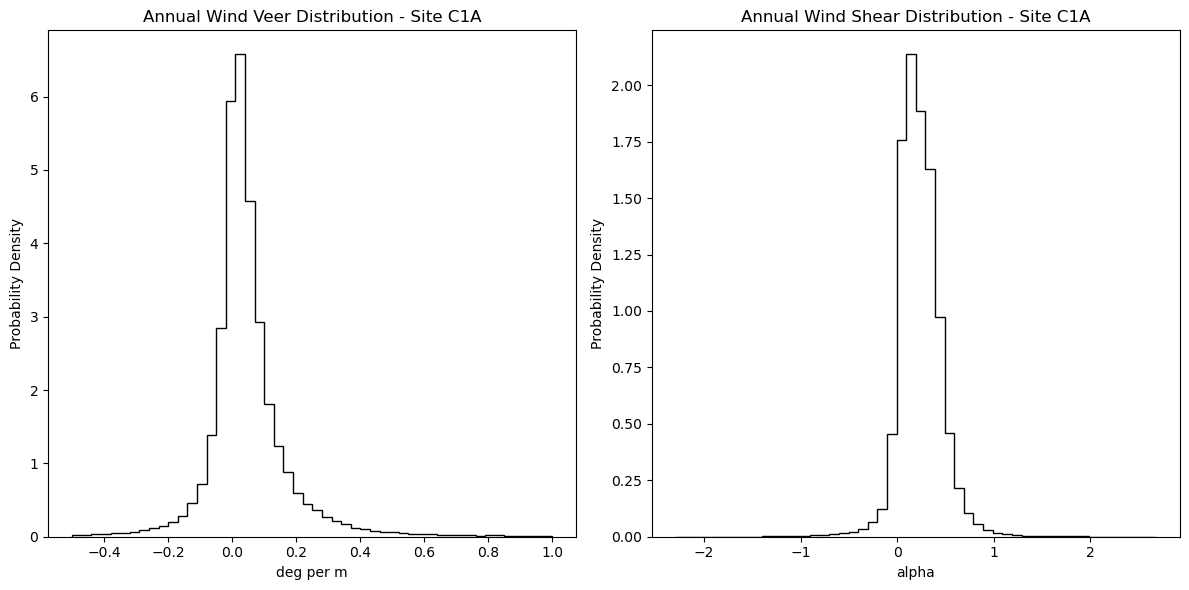

In [54]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', histtype='step',range=[-0.5,1.0], density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - Site C1A')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - Site C1A')

# Show the plot
plt.tight_layout()
plt.show()


## Annual A2

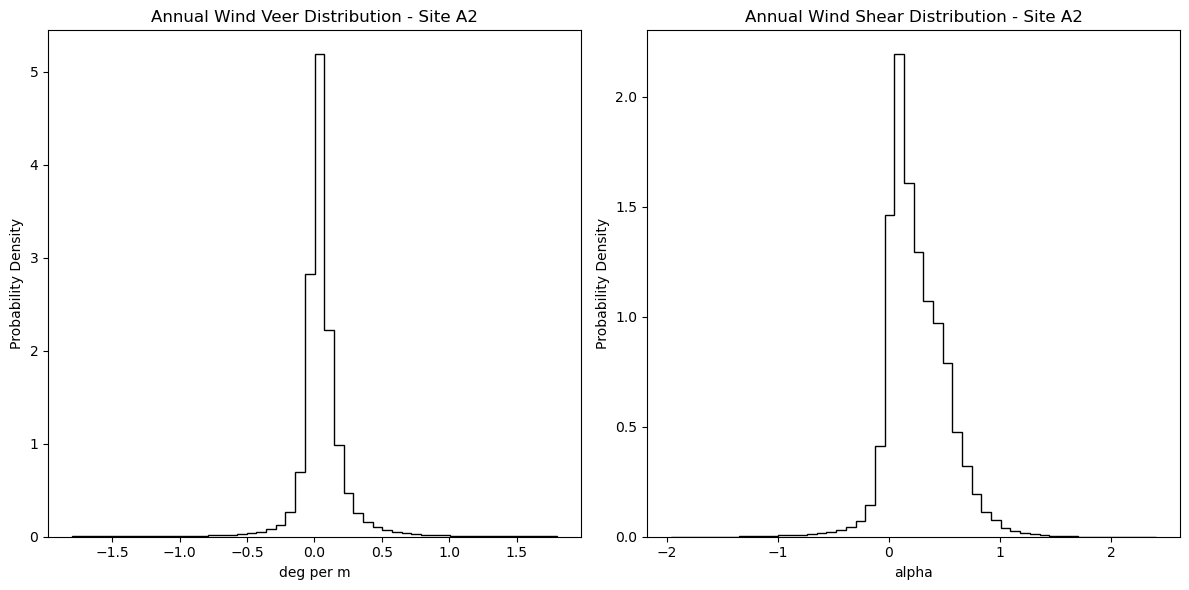

In [1411]:

# Create the histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Wind Veer distribution on the first subplot
axs[0].hist(wind_veer, bins=50, edgecolor='black', histtype='step', density=True)
axs[0].set_xlabel('deg per m')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Annual Wind Veer Distribution - Site A2')

# Plot the Wind Shear distribution on the second subplot
axs[1].hist(wind_shear, bins=50, edgecolor='black', histtype='step', density=True)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Annual Wind Shear Distribution - Site A2')

# Show the plot
plt.tight_layout()
plt.show()


In [110]:
#leaving this here for reference, daily avgs no error bars no histograms
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer and wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, wind_veer, and wind_shear match
    if not (len(times) == len(wind_veer) == len(wind_shear)):
        raise ValueError("The lengths of 'times', 'wind_veer', and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping by time_of_day to compute the mean for each hour
    df_grouped = df.groupby('time_of_day').agg({
        'wind_veer': 'mean',
        'wind_shear': 'mean'
    }).reindex(all_times, fill_value=np.nan)

    # Normalize wind shear to match the scale of wind veer for visualization
    wind_shear_normalized = df_grouped['wind_shear'] / df_grouped['wind_shear'].max() * df_grouped['wind_veer'].max()

    # Plotting the data
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(df_grouped.index, df_grouped['wind_veer'], color='blue', alpha=0.6, label='Wind Veer')
    ax.plot(df_grouped.index, wind_shear_normalized, color='red', marker='o', linestyle='-', label='Wind Shear')

    # Labels and title
    ax.set_xlabel('Time of Day (UTC)', fontsize=12)
    ax.set_ylabel('Wind Veer (deg)', fontsize=12)
    ax.set_title(f'Daily Average Wind Veer and Shear: {start_date.date()} to {end_date.date()}', fontsize=14)

    # Add a legend
    ax.legend()

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')

    # Adjust the y-axis range to ensure both plots fit well
    ax.set_ylim(0, max(df_grouped['wind_veer'].max(), wind_shear_normalized.max()) * 1.1)

    plt.tight_layout()
    plt.show()
'''

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings # Added to suppress warnings if needed

def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer and wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, wind_veer, and wind_shear match
    if not (len(times) == len(wind_veer) == len(wind_shear)):
        # Handle empty inputs gracefully, as this can happen for months with 0 data
        if len(times) == 0:
            print("No data for this period. Skipping plot.")
            return # Exit the function early
        raise ValueError("The lengths of 'times', 'wind_veer', and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages and standard deviations (for error bars)
    # Suppress warnings for empty slices
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
        daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
        daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)
        daily_std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)

    # --- START OF FIX (Part 1) ---
    # Check if data exists BEFORE calling .idxmax() to prevent crash on empty month
    
    # Initialize plot flags and variables
    plot_max_veer = daily_avg_veer.notna().any()
    plot_max_shear = daily_avg_shear.notna().any()
    max_veer_value, max_veer_time_str, max_veer_time_idx = np.nan, None, None
    max_shear_value, max_shear_time_str, max_shear_time_idx = np.nan, None, None

    if plot_max_veer:
        max_veer_value = daily_avg_veer.max()
        max_veer_time_str = daily_avg_veer.idxmax()
        # Get the numerical index (0-23) for plotting
        max_veer_time_idx = daily_avg_veer.index.get_loc(max_veer_time_str)
        print(f"Maximum Wind Veer: {max_veer_value} deg/m at {max_veer_time_str}")
    else:
        print("No valid Wind Veer data for this period.")

    if plot_max_shear:
        max_shear_value = daily_avg_shear.max()
        max_shear_time_str = daily_avg_shear.idxmax()
        # Get the numerical index (0-23) for plotting
        max_shear_time_idx = daily_avg_shear.index.get_loc(max_shear_time_str)
        print(f"Maximum Wind Shear: {max_shear_value} m/s/m at {max_shear_time_str}")
    else:
        print("No valid Wind Shear data for this period.")
    # --- END OF FIX (Part 1) ---

    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Shift the x-values of the Wind Shear error bars and line plot slightly to the right
    shift_value = 0.1  # Adjust this value to your needs
    
    # Plot Wind Veer with error bars (blue) on top of histogram
    ax1.errorbar(
        daily_avg_veer.index, daily_avg_veer.values, 
        yerr=daily_std_veer.values, fmt='o', color='blue', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    veer_line, = ax1.plot(
        daily_avg_veer.index, daily_avg_veer.values, 
        color='blue', linestyle='--', label='Wind Veer (deg/m)', zorder=1
    )
    
    # Plot Wind Shear with error bars (green) and shift the x-values by `shift_value`
    ax2 = ax1.twinx()
    shifted_x_shear = np.array(range(len(daily_avg_shear.index))) + shift_value  # Shift x-values horizontally
    ax2.errorbar(
        shifted_x_shear, daily_avg_shear.values,  # Apply shifted x-values
        yerr=daily_std_shear.values, fmt='o', color='green', 
        alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1
    )
    shear_line, = ax2.plot(
        shifted_x_shear, daily_avg_shear.values,  # Apply shifted x-values
        color='green', linestyle='-', label='Wind Shear (m/s/m)', zorder=1
    )

    # --- START OF FIX (Part 2) ---
    # Plot markers and lines *only if* they exist, using the correct numerical index

    if plot_max_veer:
        # Use the numerical index for the x-coordinate
        ax1.scatter(max_veer_time_idx, max_veer_value, color='purple', zorder=2, 
                    label='Max Veer')
        ax1.axvline(x=max_veer_time_idx, color='purple', linestyle='--', label='_nolegend_', zorder=3)

    if plot_max_shear:
        # Apply the same shift to the max shear index as the rest of the shear plot
        shifted_max_shear_idx = max_shear_time_idx + shift_value
        
        ax2.scatter(shifted_max_shear_idx, max_shear_value, color='orange', zorder=2, 
                    label='Max Shear')
        ax2.axvline(x=shifted_max_shear_idx, color='orange', linestyle='--', label='_nolegend_', zorder=3)
    # --- END OF FIX (Part 2) ---

    # Update to use correct xticks and xticklabels
    ax1.set_xticks(np.arange(len(all_times)))  # This should already give you 24 ticks
    ax1.set_xticklabels(all_times, rotation=45)
    
    ax1.set_xlabel('Time of Day (UTC)')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # CHANGEME Title for Site C1A
    ax1.set_title(f'Site C1A Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}\n'
                  f'Hub Height: 40 m to 140 m')

    # Create a proxy artist for Max Veer and Max Shear points (to avoid float handles)
    max_veer_proxy = Line2D([0], [0], marker='o', color='purple', linestyle='None', markersize=8)
    max_shear_proxy = Line2D([0], [0], marker='o', color='orange', linestyle='None', markersize=8)

    # Add legend for the lines (Veer, Shear) and Max markers only
    lines = [veer_line, shear_line]
    labels = ['Wind Veer', 'Wind Shear']
    ax1.legend(lines, labels, loc='upper left')

    # Add legend for max points (using proxy artists)
    ax2.legend(handles=[max_veer_proxy, max_shear_proxy], labels=['Max Veer', 'Max Shear'], loc='upper right')

    # Create a third axis for the frequency of the histogram (outside of the plot box)
    ax3 = ax1.twinx()  # This creates a third y-axis
    ax3.spines['right'].set_position(('outward', 60))  # Move the third axis outward
    ax3.set_ylabel('Data Percentage Available', color='gray')  # Set the label for the frequency axis
    ax3.tick_params(axis='y', labelcolor='gray')

    # Calculate the total number of days
    total_data_points = (end_date - start_date).days + 1

    # Normalize hourly counts to get percentage
    hourly_counts = df.groupby('time_of_day').size().reindex(all_times, fill_value=0)
    hourly_percentage = (hourly_counts / total_data_points) * 100

    # Plot histogram of data points at each time of day as percentages (lightgray bars at the back)
    ax3.bar(all_times, hourly_percentage, color='lightgray', alpha=0.5, label='Data Percentage', width=1.0, zorder=-2)
    
    # Add percentage ticks
    ax3.set_yticks(np.arange(0, 101, 10))
    ax3.set_yticklabels([f"{tick}%" for tick in np.arange(0, 101, 10)])

    plt.tight_layout()
    plt.show()

## Daily Monthly Averages C1A

C1A DAILY MONTHLY AVERAGES
Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not
--- Using wake-filtered df_uncontaminated data ---

 NOVEMEBER 2022
Maximum Wind Veer: 0.155 deg/m at 14:00
Maximum Wind Shear: 0.44074081608580307 m/s/m at 14:00


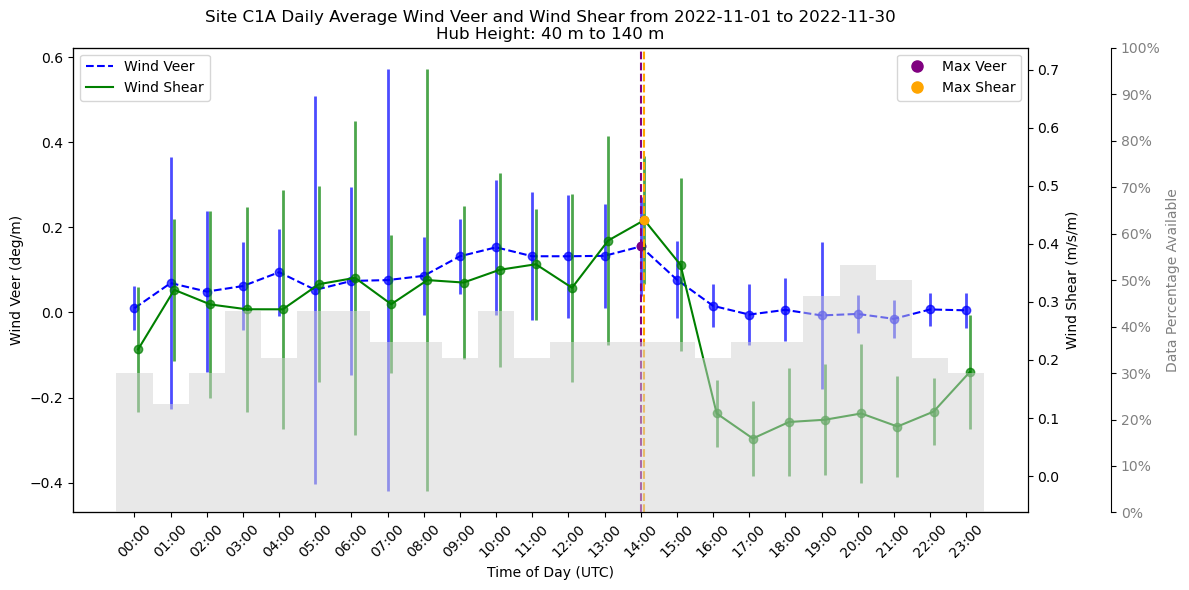


 DECEMBER 2022
Maximum Wind Veer: 0.08299999999999982 deg/m at 14:00
Maximum Wind Shear: 0.3631299092341355 m/s/m at 02:00


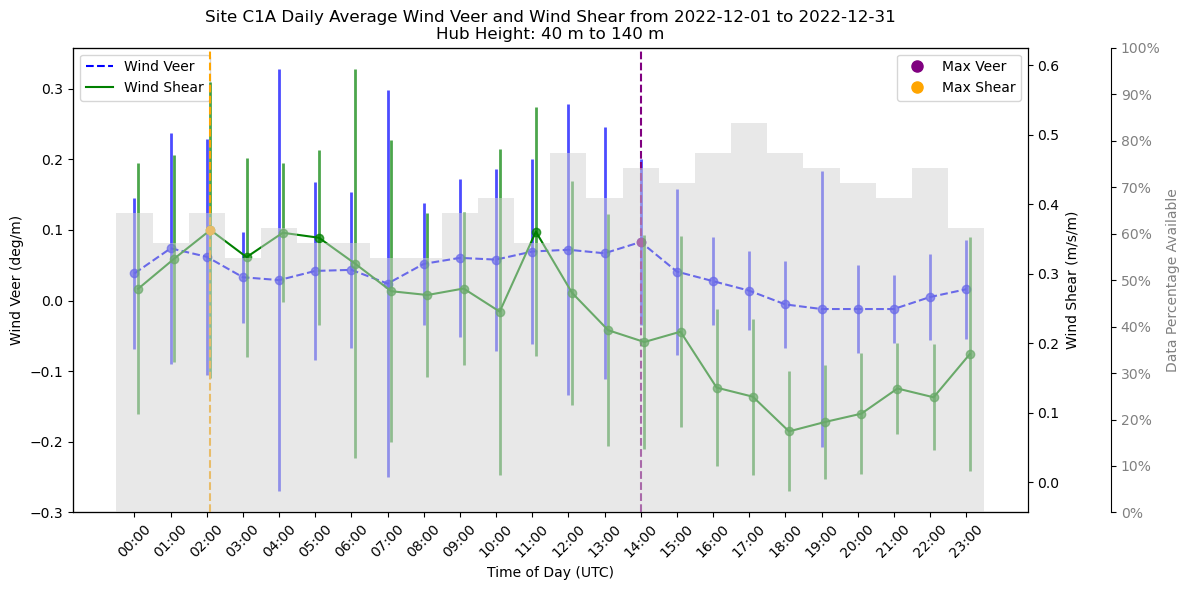


 JANUARY 2023
Maximum Wind Veer: 0.09099999999999994 deg/m at 03:00
Maximum Wind Shear: 0.3470864023007111 m/s/m at 07:00


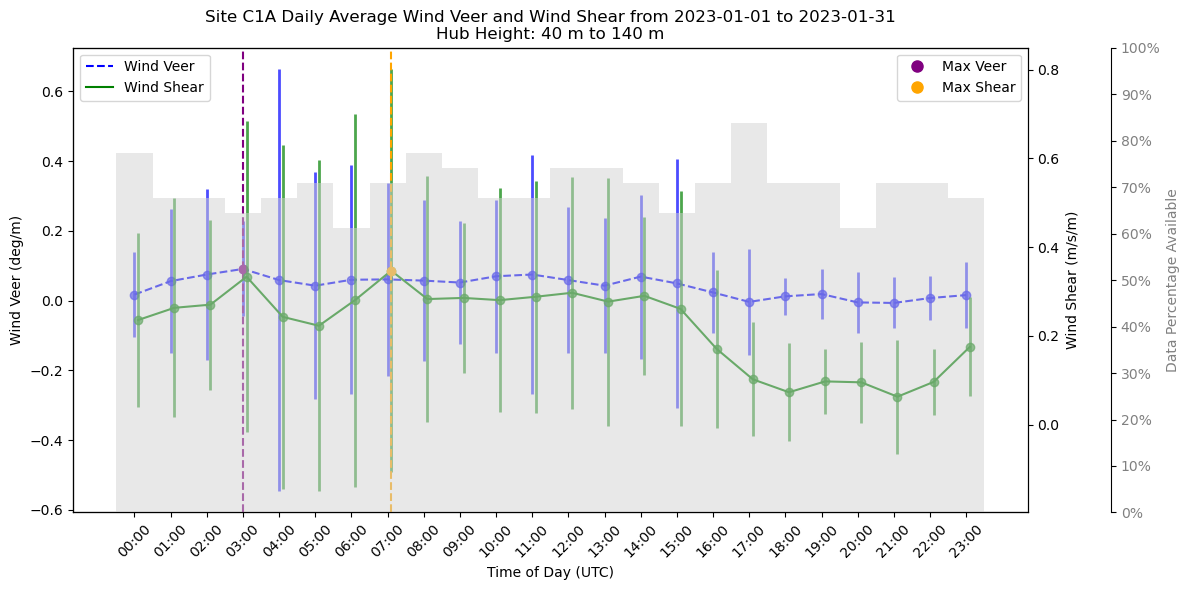


 FEBRUARY 2023
Maximum Wind Veer: 0.07450000000000004 deg/m at 13:00
Maximum Wind Shear: 0.39867346737270426 m/s/m at 05:00


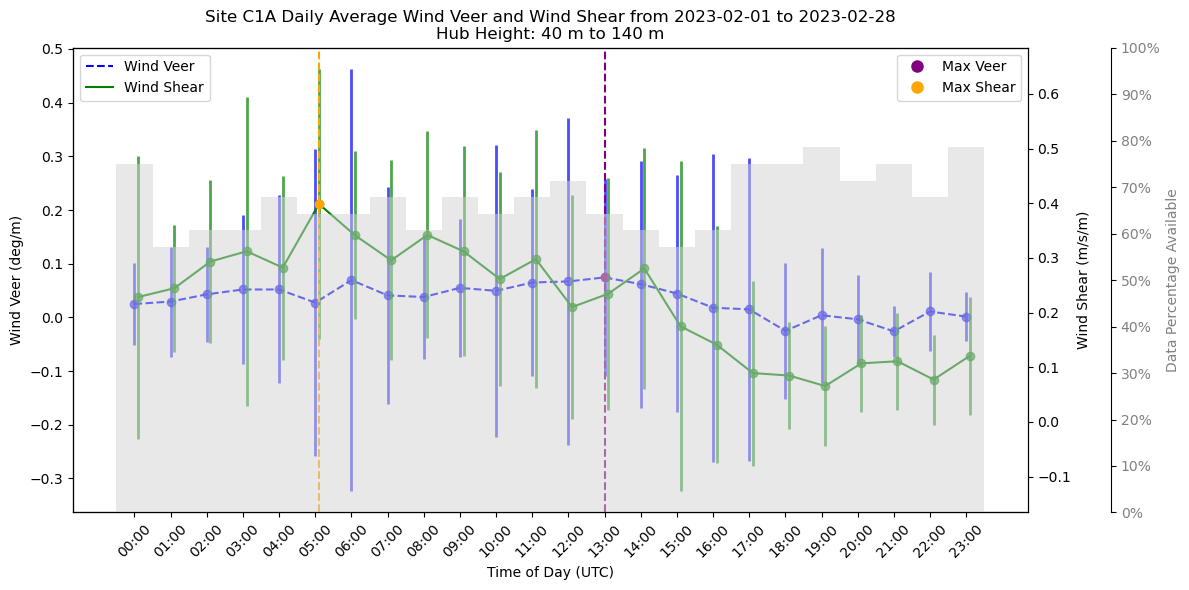


 MARCH 2023
Maximum Wind Veer: 0.07549999999999997 deg/m at 13:00
Maximum Wind Shear: 0.33314871731412365 m/s/m at 13:00


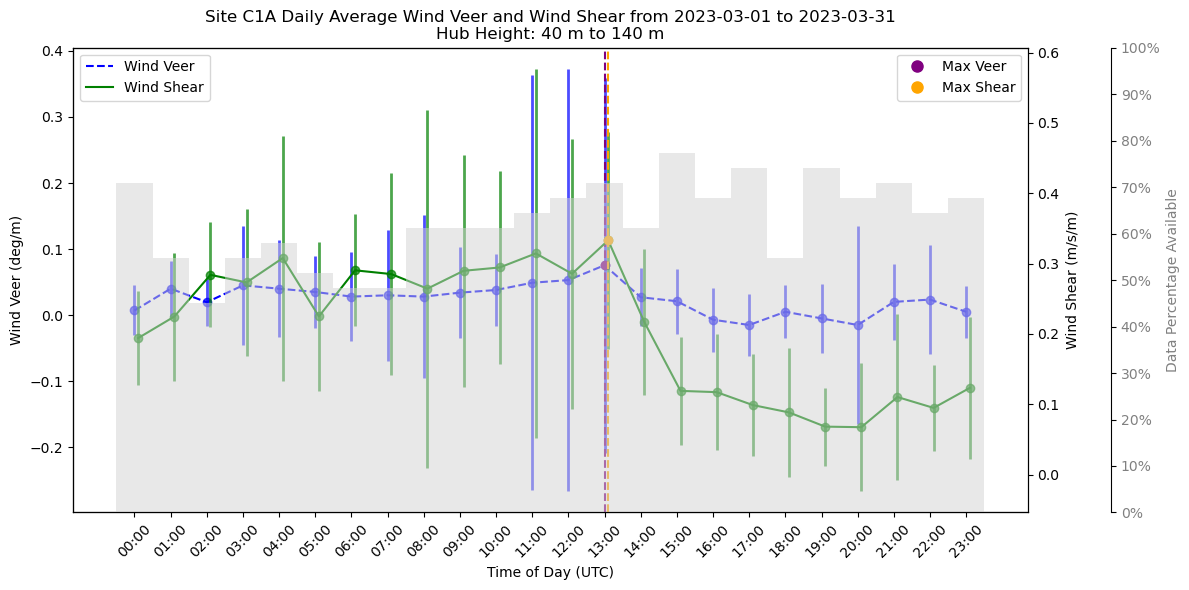


 APRIL 2023
Maximum Wind Veer: 0.09300000000000011 deg/m at 12:00
Maximum Wind Shear: 0.38900591004833907 m/s/m at 13:00


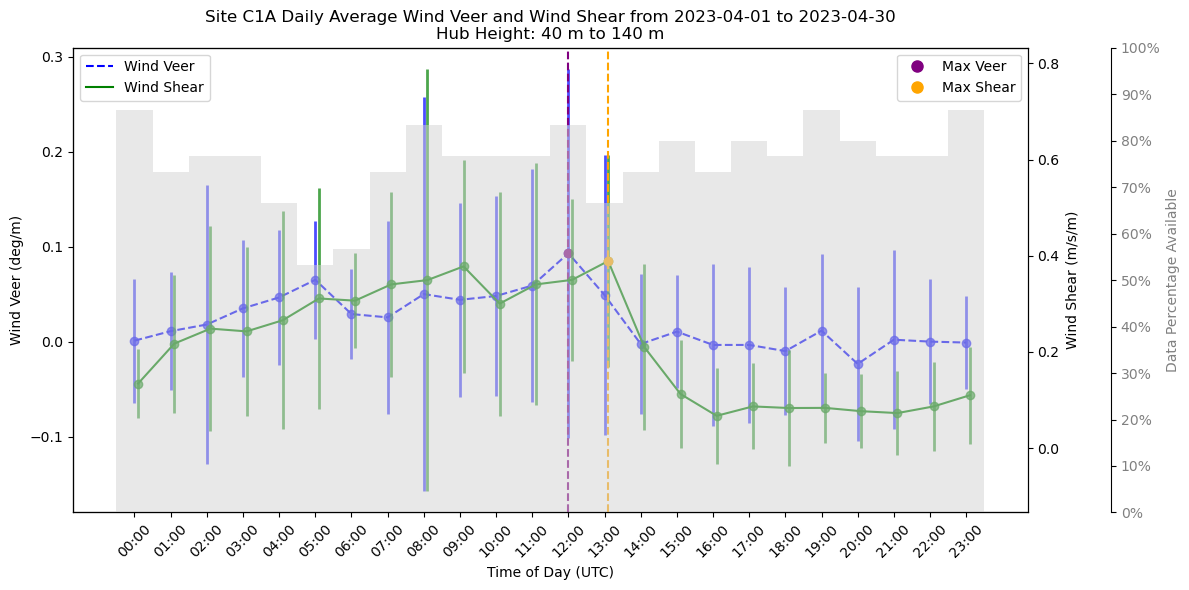


 MAY 2023
Maximum Wind Veer: 0.12 deg/m at 12:00
Maximum Wind Shear: 0.3990221738829463 m/s/m at 07:00


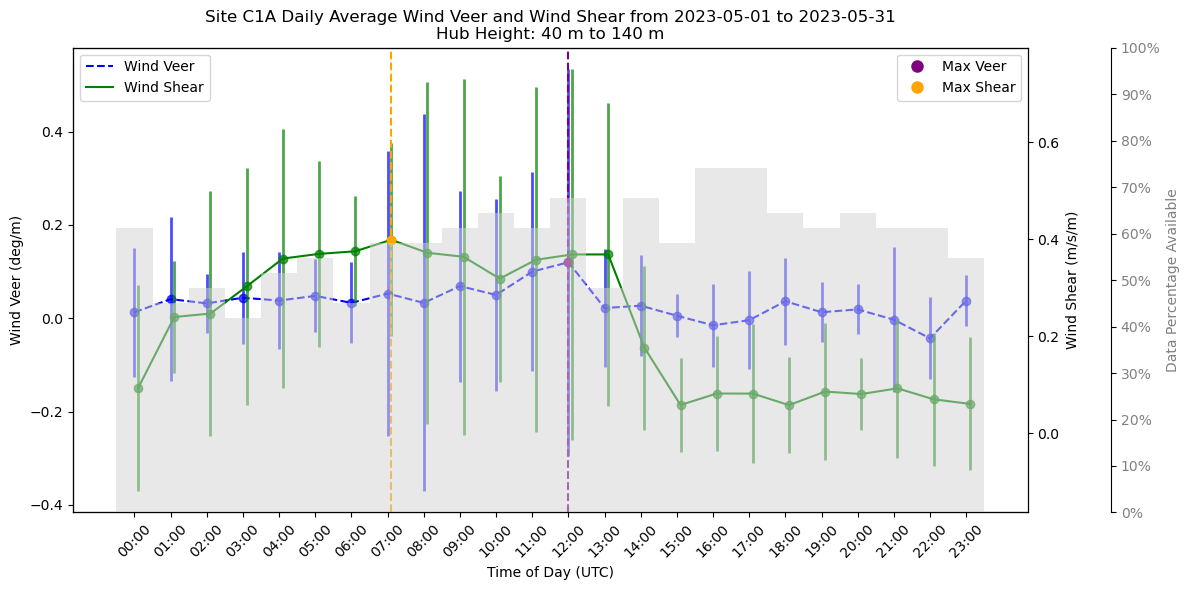


 JUNE 2023
Maximum Wind Veer: 0.09049999999999997 deg/m at 04:00
Maximum Wind Shear: 0.40418366897458047 m/s/m at 11:00


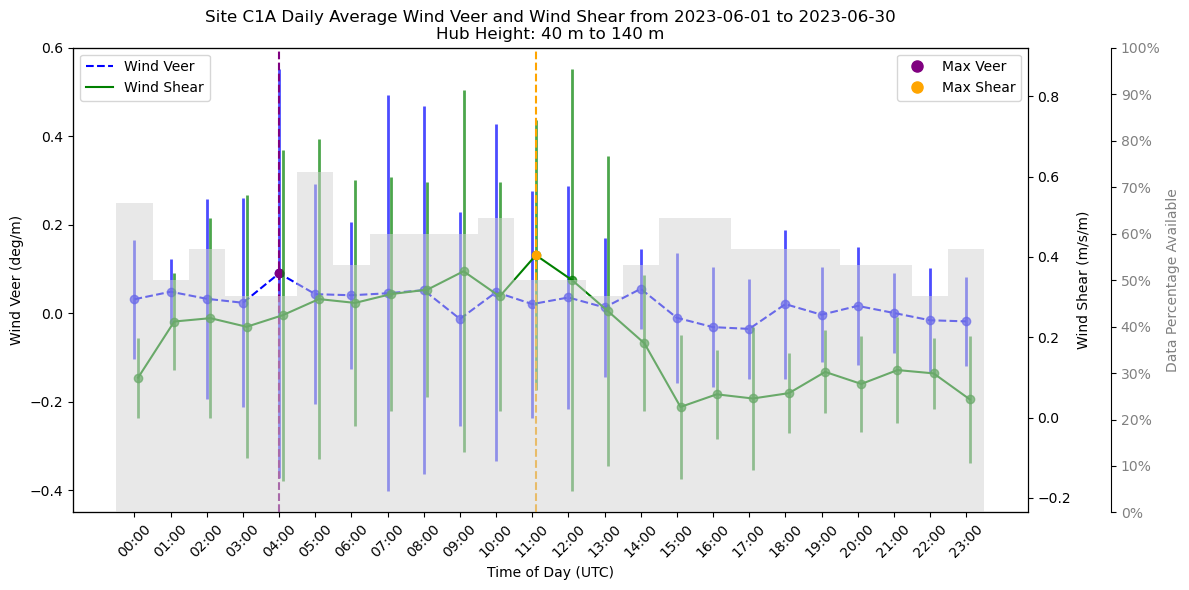


 JULY 2023
Maximum Wind Veer: 0.065 deg/m at 07:00
Maximum Wind Shear: 0.4187223958289301 m/s/m at 12:00


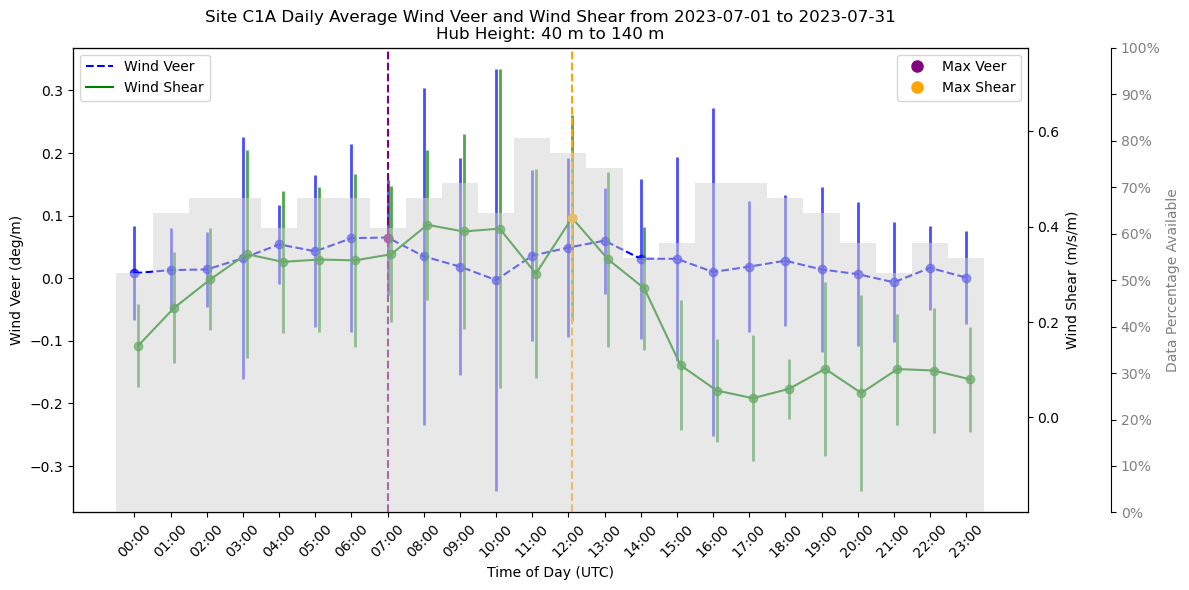


 AUGUST 2023
No valid Wind Veer data for this period.
No valid Wind Shear data for this period.


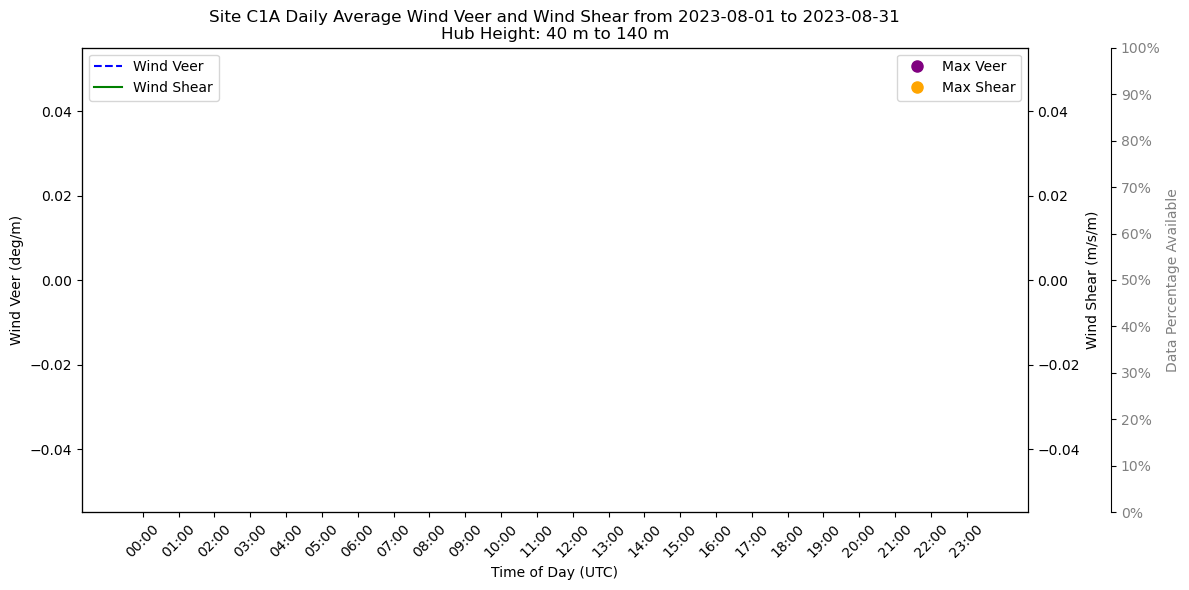


 SEPTEMBER 2023
Maximum Wind Veer: 0.09099999999999994 deg/m at 13:00
Maximum Wind Shear: 0.4426703464421961 m/s/m at 05:00


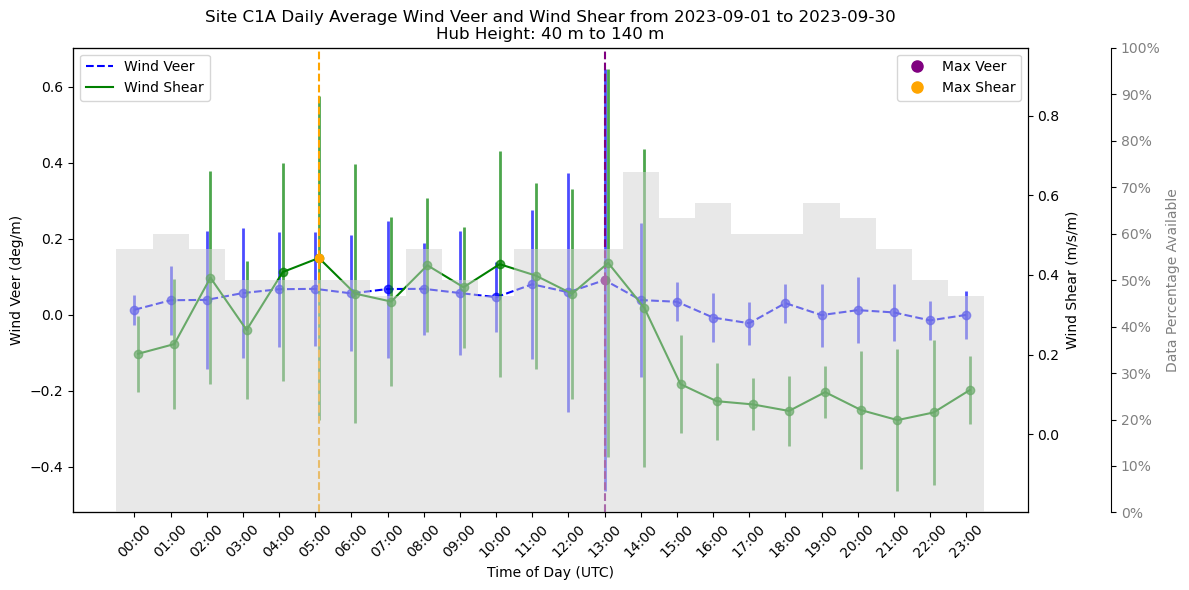


 OCTOBER 2023
Maximum Wind Veer: 0.11800000000000012 deg/m at 13:00
Maximum Wind Shear: 0.3725566651071182 m/s/m at 04:00


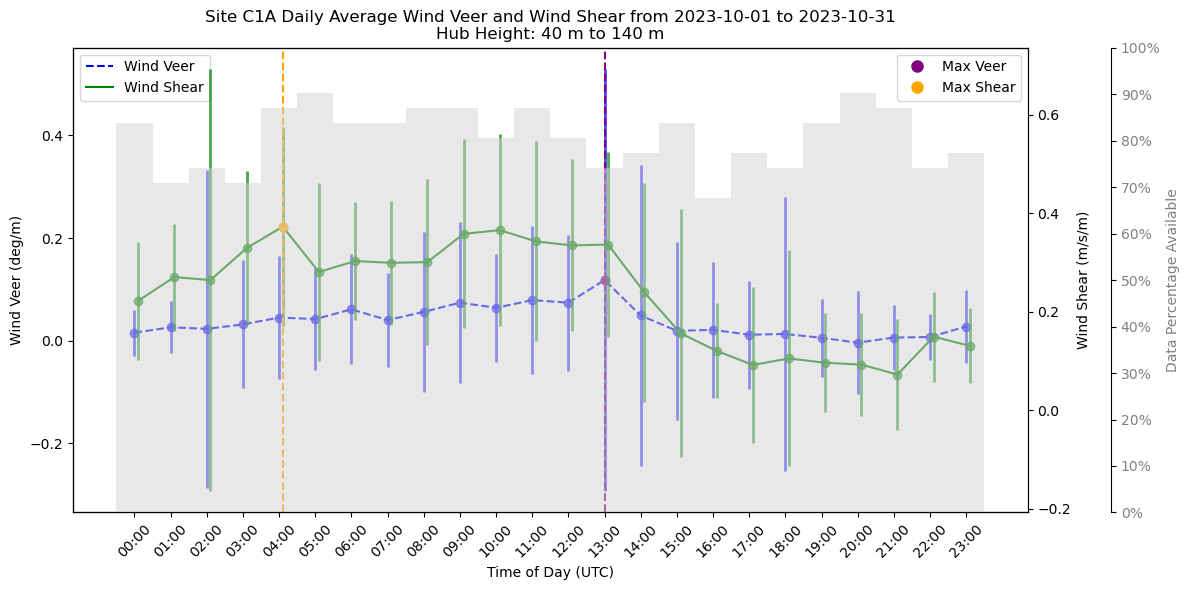


 NOVEMBER 2023
Maximum Wind Veer: 0.09900000000000006 deg/m at 05:00
Maximum Wind Shear: 0.40583349461844465 m/s/m at 05:00


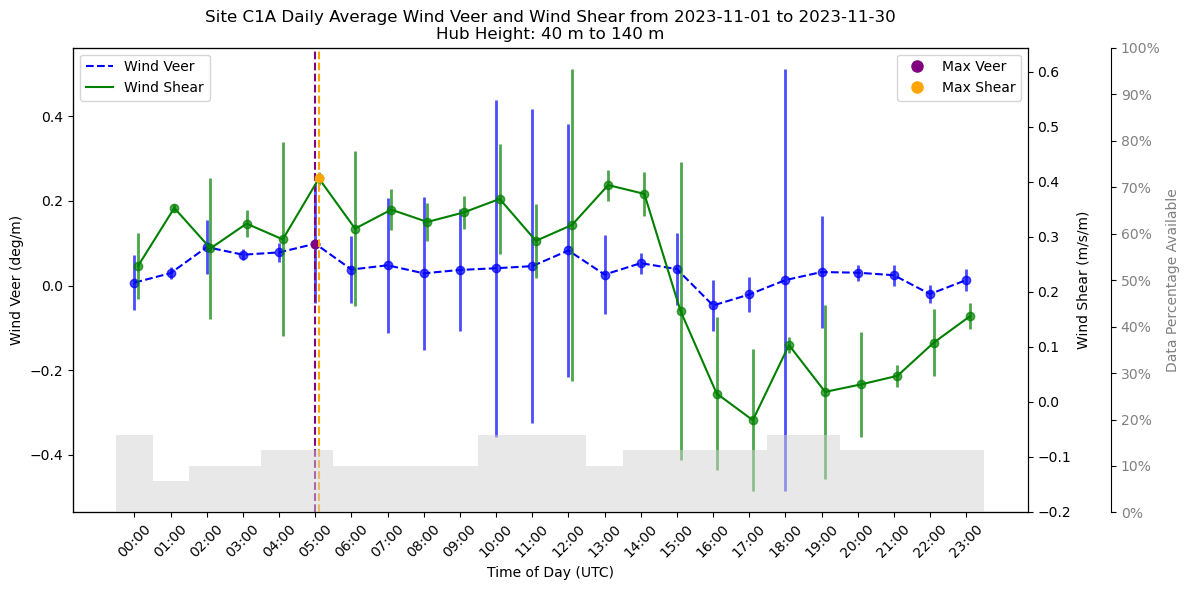

In [77]:
from datetime import timezone # Make sure this import is at the top!

print("C1A DAILY MONTHLY AVERAGES")
print("Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not")
print("--- Using wake-filtered df_uncontaminated data ---")

#for 11-2022
print("\n", "NOVEMEBER 2022")
start_date = datetime(2022, 11, 1, tzinfo=timezone.utc)
end_date = datetime(2022, 11, 30, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 12-2022
print("\n", "DECEMBER 2022")
start_date = datetime(2022, 12, 1, tzinfo=timezone.utc)
end_date = datetime(2022, 12, 31, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 01-2023
print("\n", "JANUARY 2023")
start_date = datetime(2023, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 1, 31, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 02-2023
print("\n", "FEBRUARY 2023")
start_date = datetime(2023, 2, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 2, 28, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 03-2023
print("\n", "MARCH 2023")
start_date = datetime(2023, 3, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 3, 31, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 04-2023
print("\n", "APRIL 2023")
start_date = datetime(2023, 4, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 4, 30, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 05-2023
print("\n", "MAY 2023")
start_date = datetime(2023, 5, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 5, 31, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 06-2023
print("\n", "JUNE 2023")
start_date = datetime(2023, 6, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 6, 30, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 07-2023
print("\n", "JULY 2023")
start_date = datetime(2023, 7, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 7, 31, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 08-2023
print("\n", "AUGUST 2023")
start_date = datetime(2023, 8, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 8, 31, tzinfo=timezone.utc)
monthly__df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 09-2023
print("\n", "SEPTEMBER 2023")
start_date = datetime(2023, 9, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 9, 30, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 10-2023
print("\n", "OCTOBER 2023")
start_date = datetime(2023, 10, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 10, 31, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 11-2023
print("\n", "NOVEMBER 2023")
start_date = datetime(2023, 11, 1, tzinfo=timezone.utc)
end_date = datetime(2023, 11, 30, tzinfo=timezone.utc)
monthly_df = df_uncontaminated[(df_uncontaminated['time'] >= start_date) & (df_uncontaminated['time'] <= end_date)]
times = monthly_df['time'].values
wind_veer = monthly_df['veer_lidar'].values
wind_shear = monthly_df['shear_lidar'].values
plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

## Daily Averages for A2

A2 DAILY MONTHLY AVERAGES
Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not

 NOVEMEBER 2022
Start Date:  2022-11-11 00:00:00
End Date:  2022-11-30 00:00:00
Maximum Wind Veer: 0.31 deg/m at 14:00
Maximum Wind Shear: 0.5478855829301474 m/s/m at 11:00


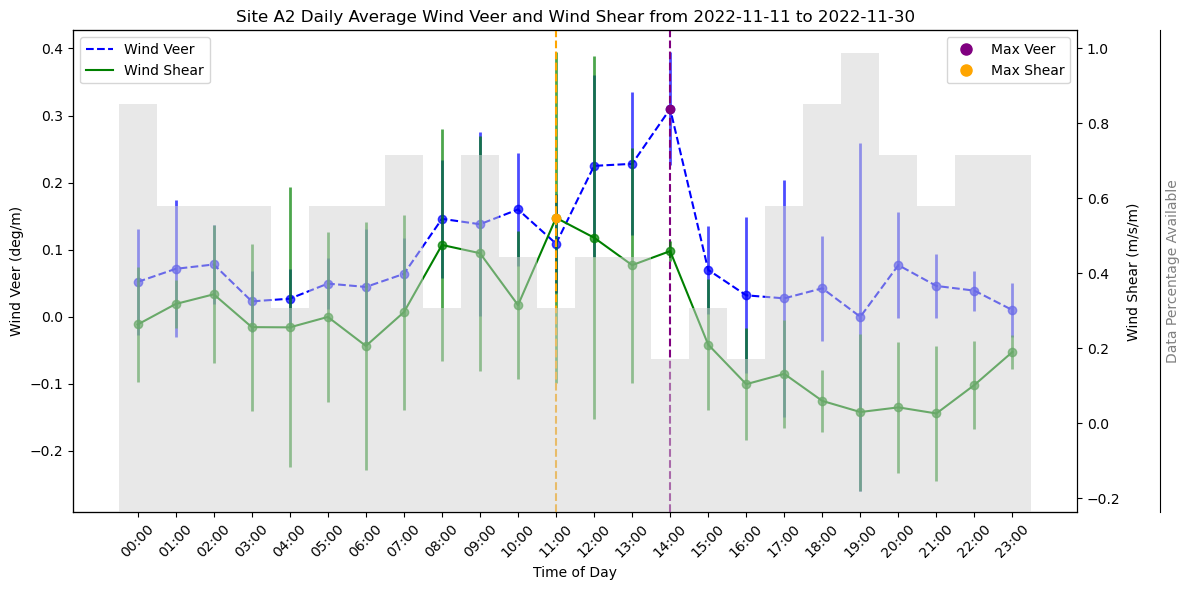


 DECEMBER 2022
Start Date:  2022-12-01 00:00:00
End Date:  2022-12-31 00:00:00
Maximum Wind Veer: 0.15600000000000008 deg/m at 04:00
Maximum Wind Shear: 0.3242700231941176 m/s/m at 02:00


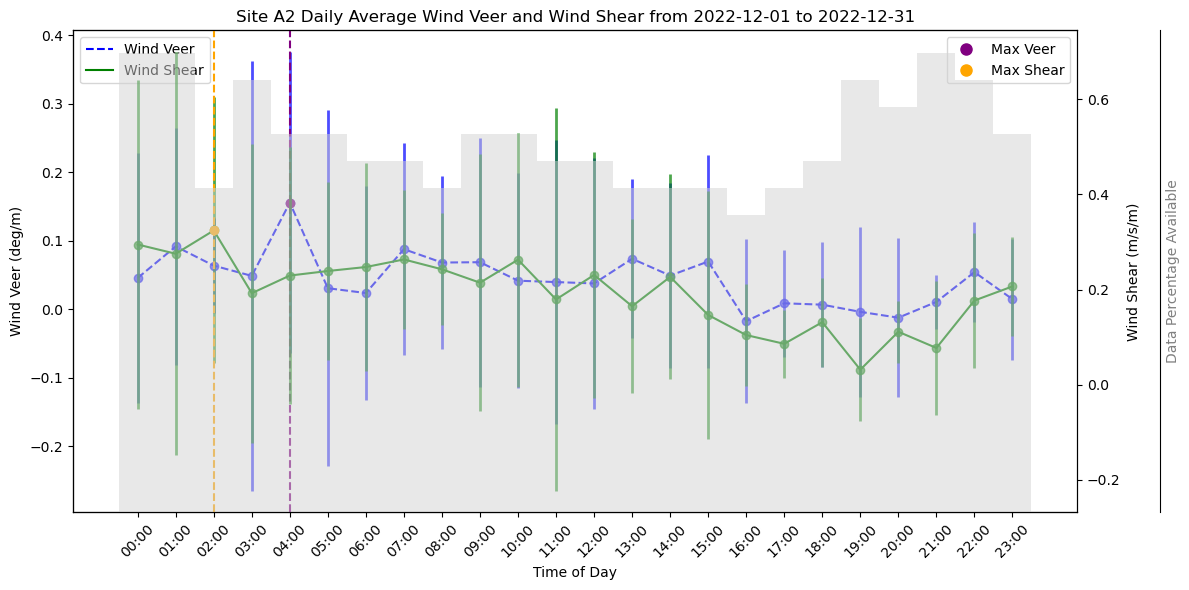


 JANUARY 2023
Start Date:  2023-01-01 00:00:00
End Date:  2023-01-31 00:00:00
Maximum Wind Veer: 0.1594999999999999 deg/m at 12:00
Maximum Wind Shear: 0.5890221053450362 m/s/m at 07:00


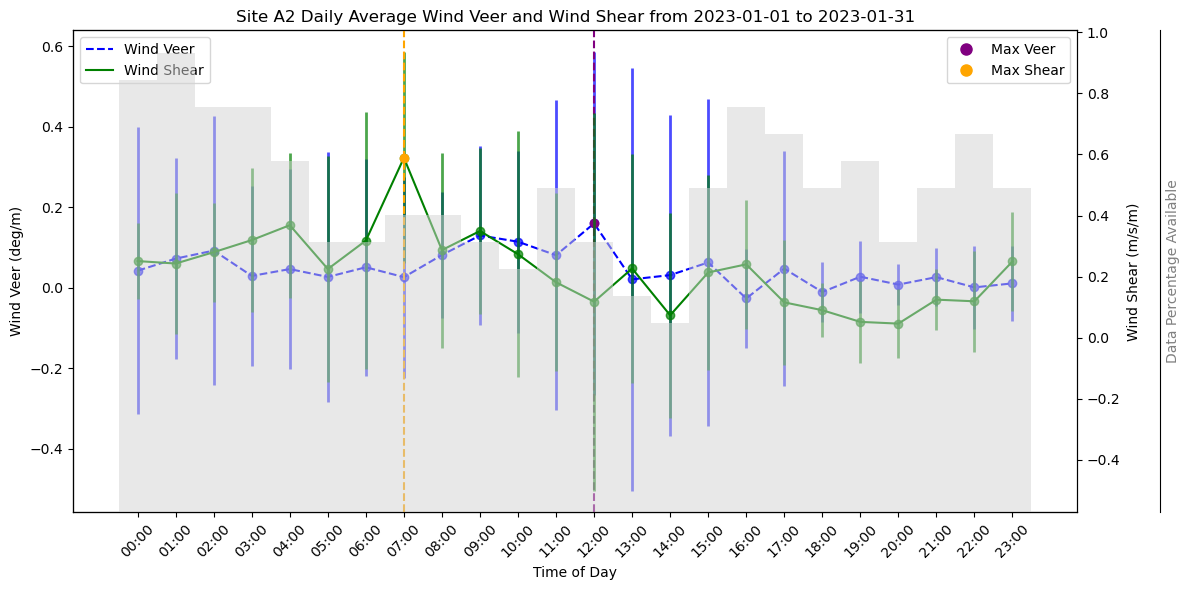


 FEBRUARY 2023
Start Date:  2023-02-01 00:00:00
End Date:  2023-02-28 00:00:00
Maximum Wind Veer: 0.11799999999999983 deg/m at 12:00
Maximum Wind Shear: 0.4544599372736912 m/s/m at 05:00


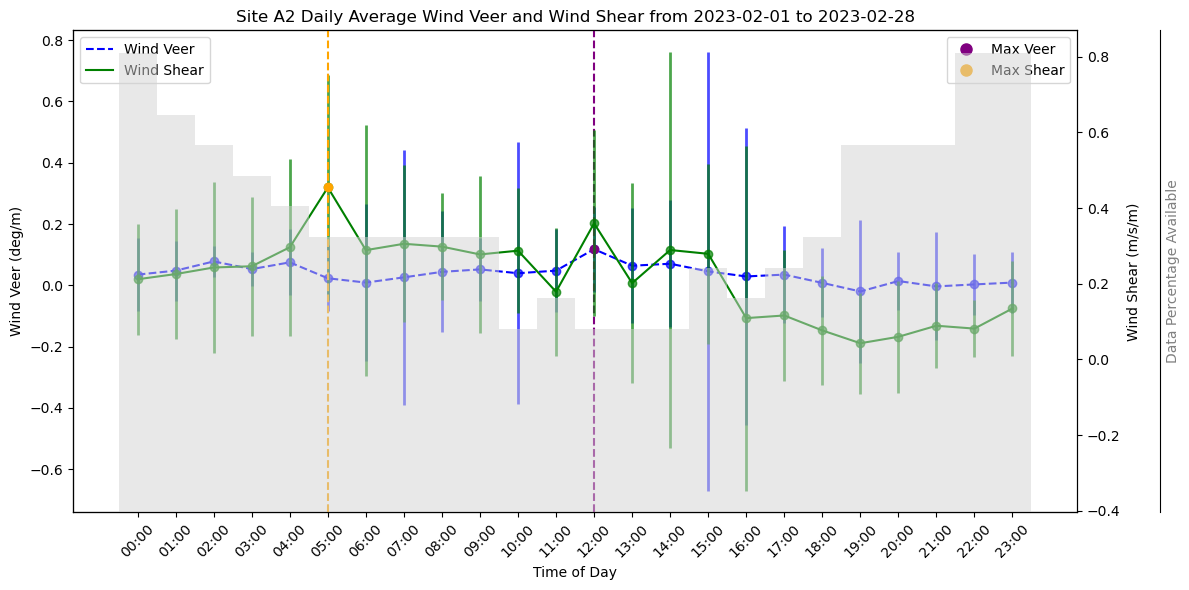


 MARCH 2023
Start Date:  2023-03-01 00:00:00
End Date:  2023-03-31 00:00:00
Maximum Wind Veer: 0.08299999999999996 deg/m at 08:00
Maximum Wind Shear: 0.30522086214981287 m/s/m at 03:00


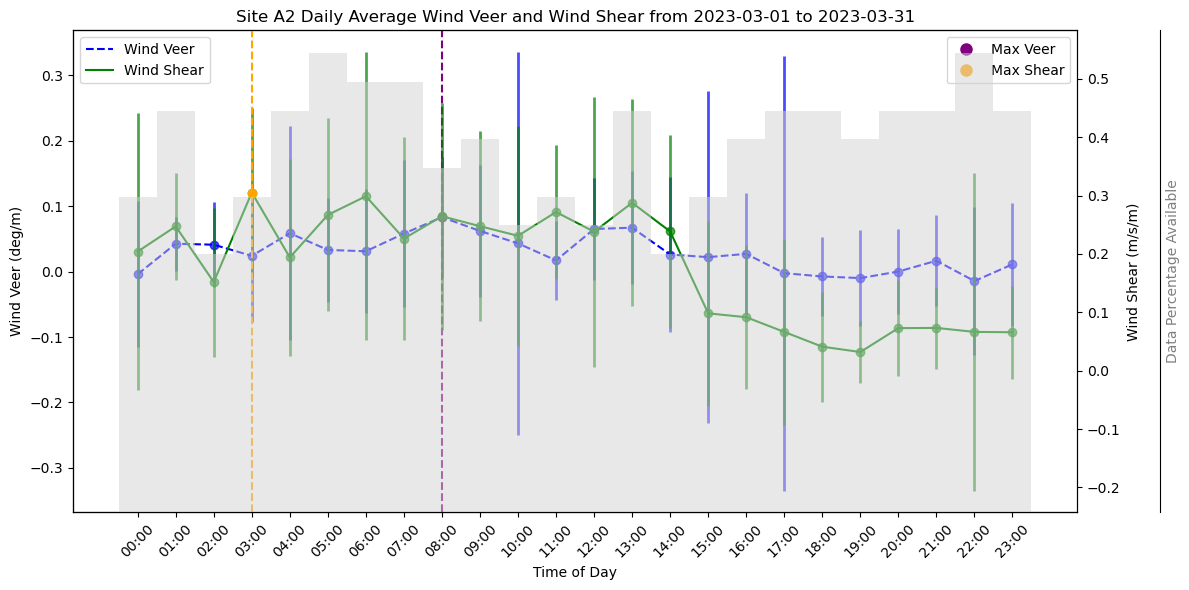


 APRIL 2023
Start Date:  2023-04-01 00:00:00
End Date:  2023-04-30 00:00:00
Maximum Wind Veer: 0.06400000000000006 deg/m at 14:00
Maximum Wind Shear: 0.3954214627881783 m/s/m at 13:00


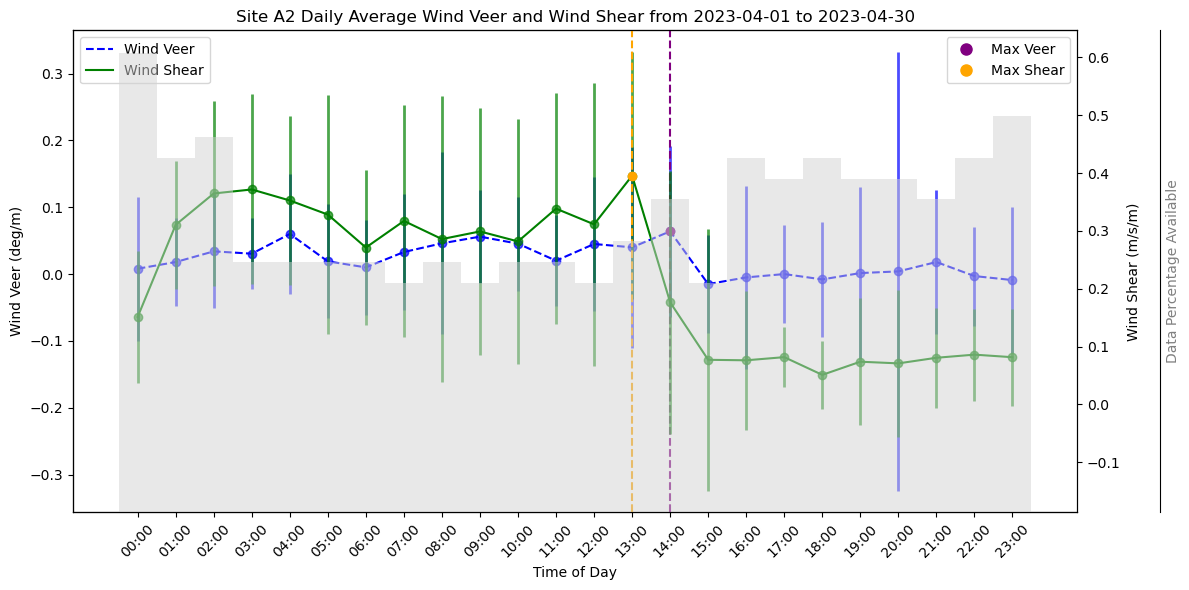


 MAY 2023
Start Date:  2023-05-01 00:00:00
End Date:  2023-05-31 00:00:00
Maximum Wind Veer: 0.12599999999999995 deg/m at 12:00
Maximum Wind Shear: 0.5365720181334476 m/s/m at 12:00


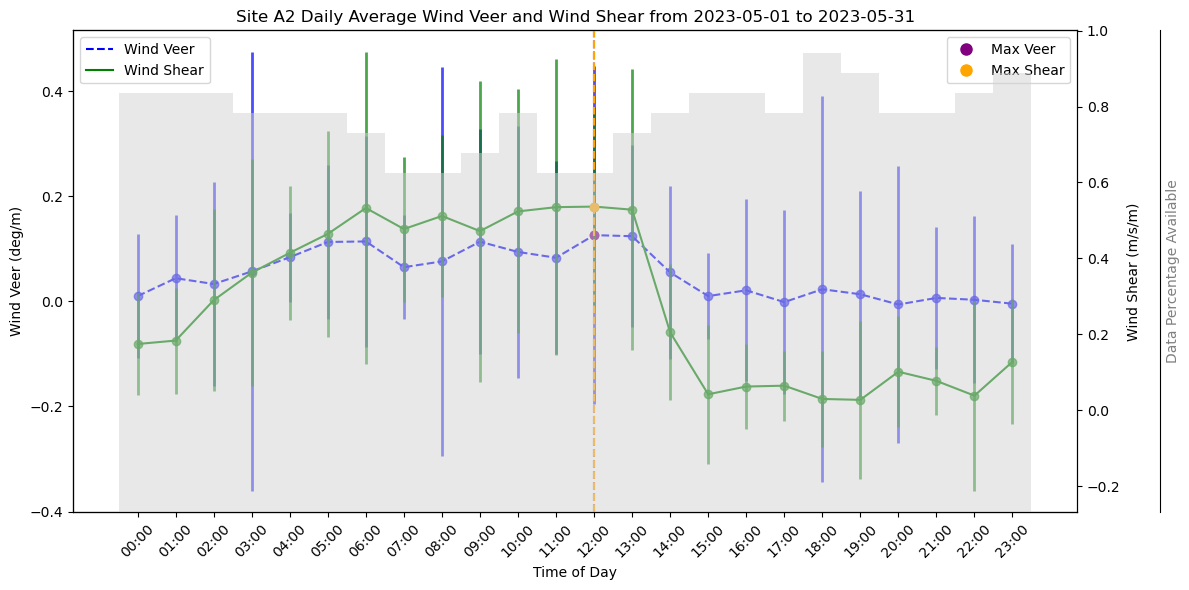


 JUNE 2023
Start Date:  2023-06-01 00:00:00
End Date:  2023-06-30 00:00:00
Maximum Wind Veer: 0.09350000000000008 deg/m at 12:00
Maximum Wind Shear: 0.5209473396312808 m/s/m at 10:00


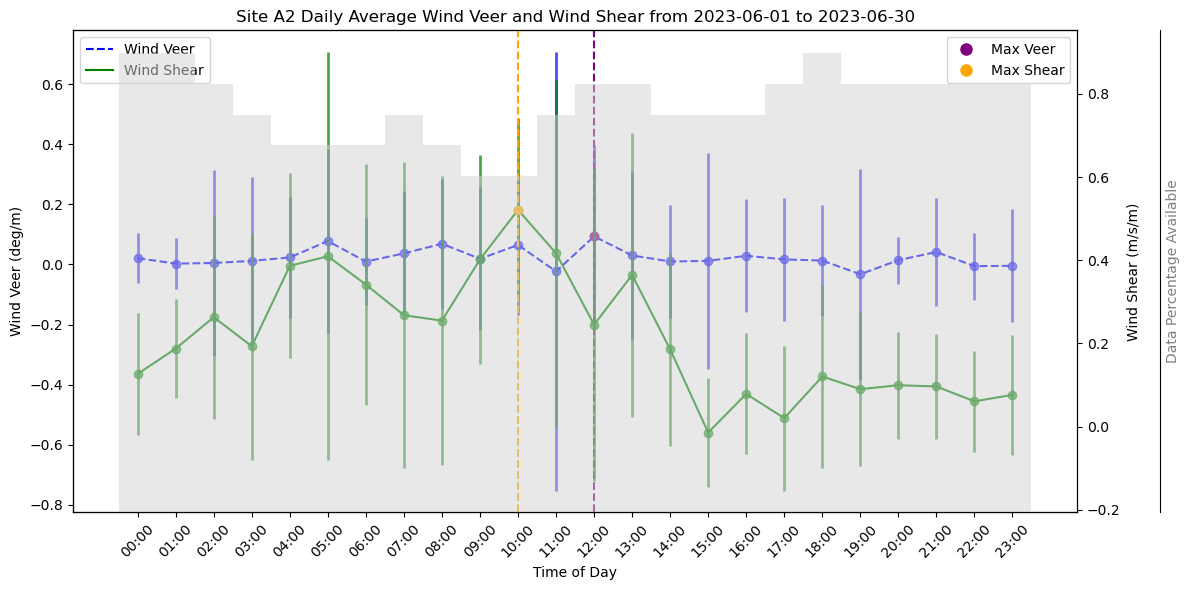


 JULY 2023
Start Date:  2023-07-01 00:00:00
End Date:  2023-07-31 00:00:00
Maximum Wind Veer: 0.08700000000000002 deg/m at 05:00
Maximum Wind Shear: 0.48131015507847313 m/s/m at 09:00


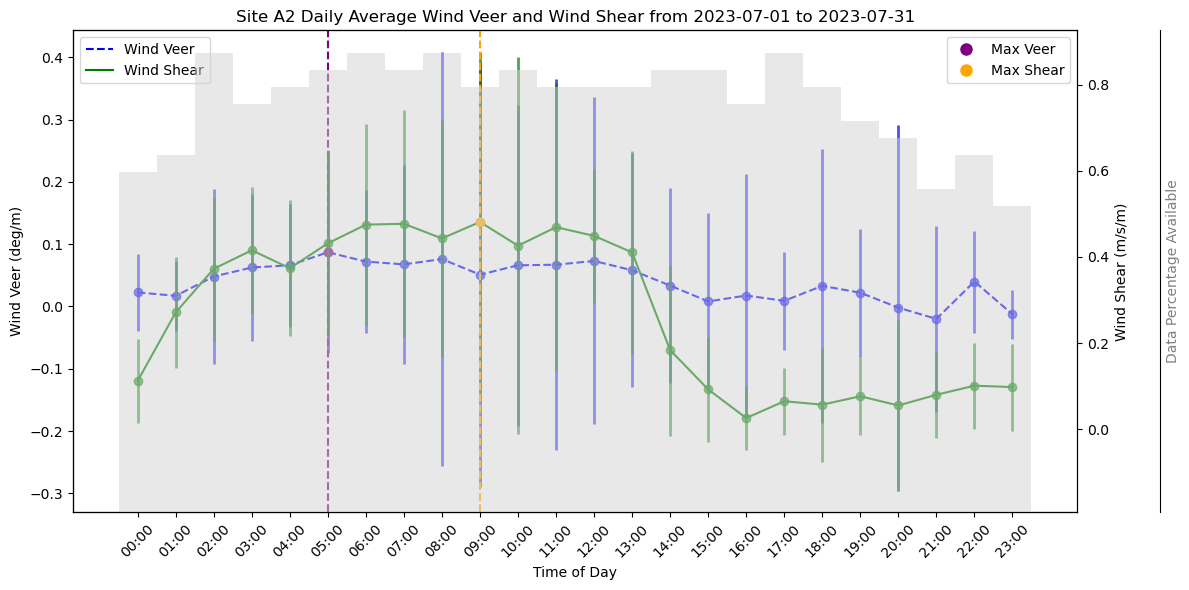


 AUGUST 2023
Start Date:  2023-08-01 00:00:00
End Date:  2023-08-31 00:00:00
Maximum Wind Veer: 0.1210000000000001 deg/m at 10:00
Maximum Wind Shear: 0.544901033736891 m/s/m at 08:00


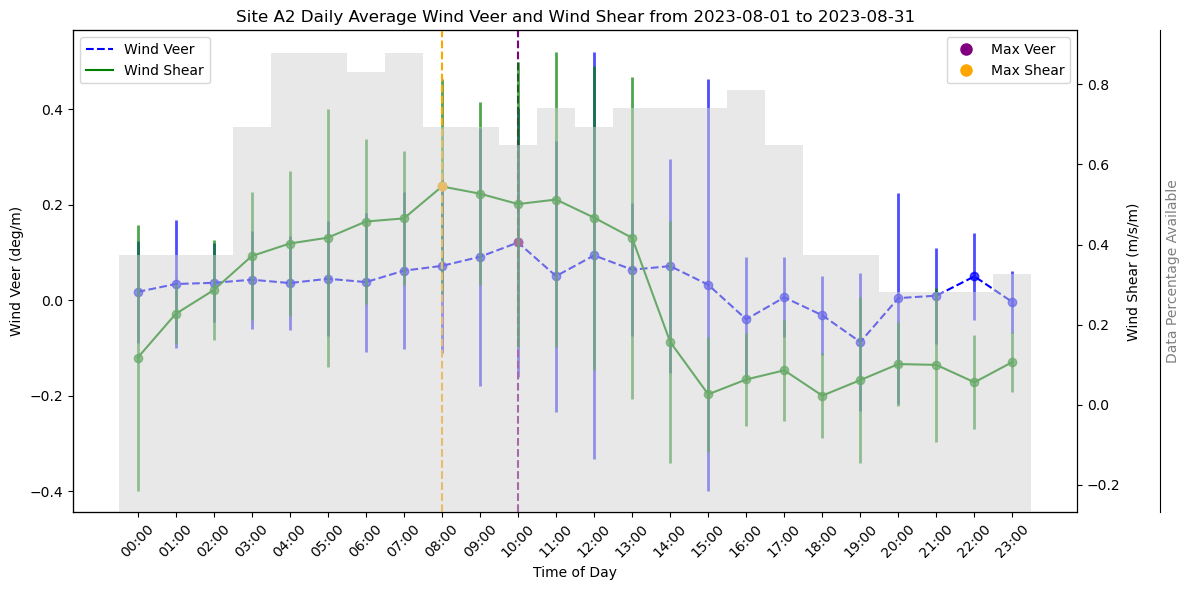


 SEPTEMBER 2023
Start Date:  2023-09-01 00:00:00
End Date:  2023-09-30 00:00:00
Maximum Wind Veer: 0.1269999999999999 deg/m at 12:00
Maximum Wind Shear: 0.6594492458455428 m/s/m at 11:00


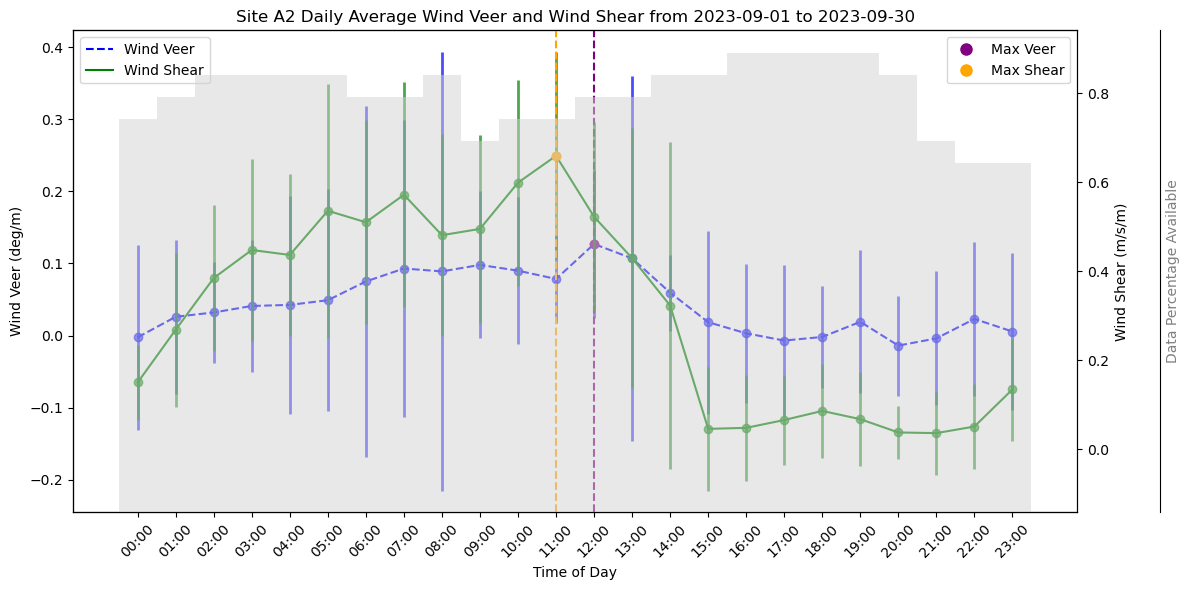


 OCTOBER 2023
Start Date:  2023-10-01 00:00:00
End Date:  2023-10-31 00:00:00
Maximum Wind Veer: 0.11300000000000011 deg/m at 13:00
Maximum Wind Shear: 0.49378917506376274 m/s/m at 13:00


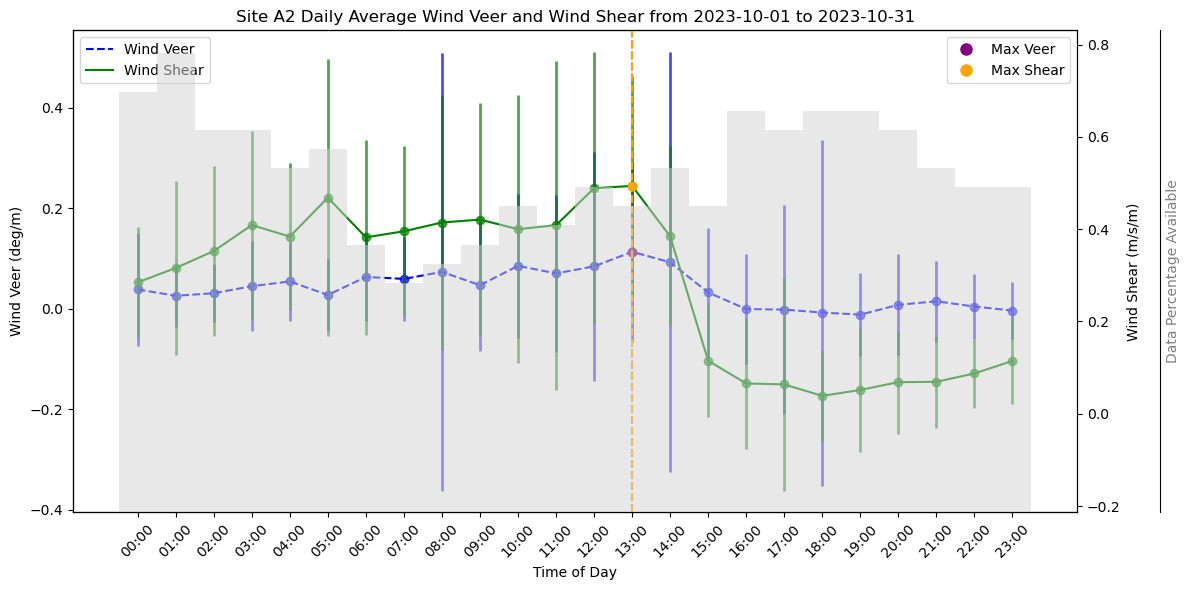


 NOVEMBER 2023
Start Date:  2023-11-01 00:00:00
End Date:  2023-11-06 00:00:00
Maximum Wind Veer: 0.5935000000000001 deg/m at 09:00
Maximum Wind Shear: 1.2648549310358592 m/s/m at 11:00


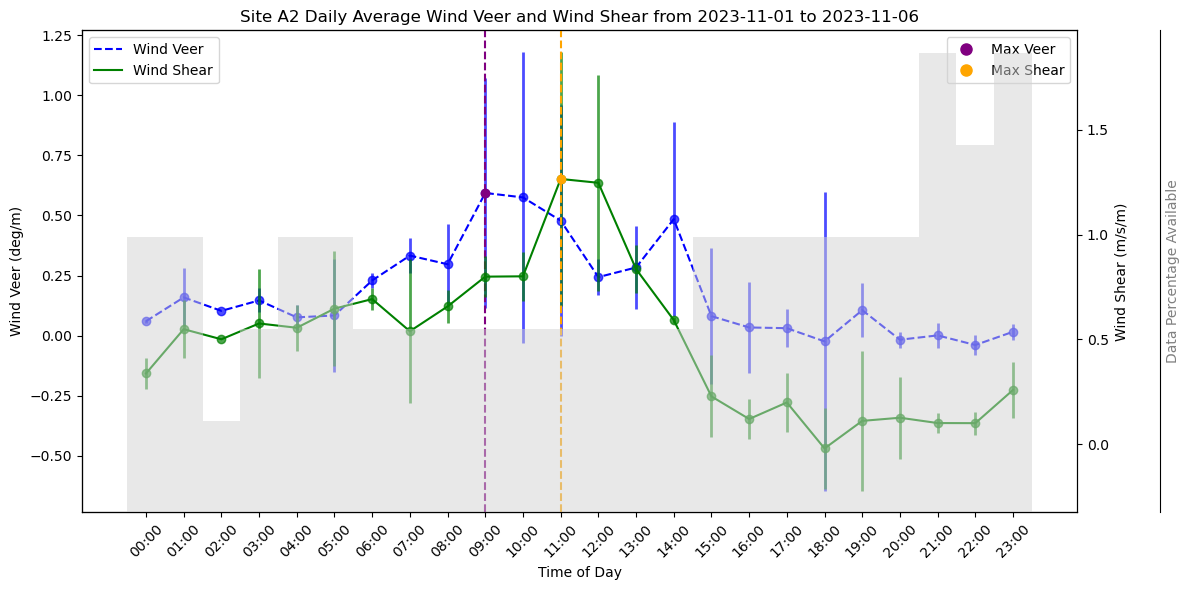

In [40]:
print("A2 DAILY MONTHLY AVERAGES")
print("Note: C1A has more data so includes full Novemeber 2022 and November 2023, A2 does not")

#for 11-2022
print("\n", "NOVEMEBER 2022")
start_date = datetime(2022, 11, 11)
end_date = datetime(2022, 11, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 12-2022
print("\n", "DECEMBER 2022")
start_date = datetime(2022,12,1)
end_date = datetime(2022, 12, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 01-2023
print("\n", "JANUARY 2023")
start_date = datetime(2023,1,1)
end_date = datetime(2023, 1, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 02-2023
print("\n", "FEBRUARY 2023")
start_date = datetime(2023,2,1)
end_date = datetime(2023, 2, 28)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 03-2023
print("\n", "MARCH 2023")
start_date = datetime(2023,3,1)
end_date = datetime(2023, 3, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 04-2023
print("\n", "APRIL 2023")
start_date = datetime(2023,4,1)
end_date = datetime(2023, 4, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 05-2023
print("\n", "MAY 2023")
start_date = datetime(2023,5,1)
end_date = datetime(2023, 5, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 06-2023
print("\n", "JUNE 2023")
start_date = datetime(2023,6,1)
end_date = datetime(2023, 6, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 07-2023
print("\n", "JULY 2023")
start_date = datetime(2023,7,1)
end_date = datetime(2023, 7, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 08-2023
print("\n", "AUGUST 2023")
start_date = datetime(2023,8,1)
end_date = datetime(2023, 8, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 09-2023
print("\n", "SEPTEMBER 2023")
start_date = datetime(2023,9,1)
end_date = datetime(2023, 9, 30)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 10-2023
print("\n", "OCTOBER 2023")
start_date = datetime(2023,10,1)
end_date = datetime(2023, 10, 31)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

#for 11-2023 (end date is later than A2 - can do full month)
print("\n", "NOVEMBER 2023")
start_date = datetime(2023,11,1)
end_date = datetime(2023, 11, 6)
times, wind_veer = calculate_wind_veer(matching_files, start_date=start_date, end_date=end_date)
times, wind_shear = calculate_wind_shear_with_alpha(matching_files, start_date=start_date, end_date=end_date)

plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotDailyAverageCompare(times1, wind_veer1, wind_shear1, start_date1, end_date1, 
                            times2, wind_veer2, wind_shear2, start_date2, end_date2):
    """
    Plots daily average wind veer and wind shear from two different time periods on the same graph.
    The x-axis represents the time of day (00:00 to 23:59, UTC), with error bars for both datasets.
    """
    def process_data(times, wind_veer, wind_shear, start_date, end_date):
        """Helper function to filter and process data."""
        # Convert times to datetime and localize to UTC if not already
        times = pd.to_datetime(times)
        if times.tzinfo is None:
            times = times.tz_localize('UTC')

        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        if start_date.tzinfo is None:
            start_date = start_date.tz_localize('UTC')
        if end_date.tzinfo is None:
            end_date = end_date.tz_localize('UTC')

        # Create DataFrame and filter by date range
        df = pd.DataFrame({
            'time': times,
            'wind_veer': wind_veer,
            'wind_shear': wind_shear
        })
        df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

        # Extract time of day
        df['time_of_day'] = df['time'].dt.strftime('%H:%M')

        # Create a complete index for all times of day (24 hours)
        all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

        # Group by time of day to calculate daily averages and standard deviations
        avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
        avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
        std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)
        std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)

        return avg_veer, avg_shear, std_veer, std_shear, all_times

    # Process data for both time periods
    avg_veer1, avg_shear1, std_veer1, std_shear1, all_times1 = process_data(
        times1, wind_veer1, wind_shear1, start_date1, end_date1
    )
    avg_veer2, avg_shear2, std_veer2, std_shear2, all_times2 = process_data(
        times2, wind_veer2, wind_shear2, start_date2, end_date2
    )

    # Verify that both time periods cover the same time of day
    if not all_times1.equals(all_times2):
        raise ValueError("The two time periods must cover the same time of day range.")

    # Plot the data
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Wind Veer for both time periods
    ax1.errorbar(
        avg_veer1.index, avg_veer1.values, yerr=std_veer1.values, 
        fmt='o', color='blue', alpha=0.7, elinewidth=1.5, label='Veer Period 1'
    )
    ax1.errorbar(
        avg_veer2.index, avg_veer2.values, yerr=std_veer2.values, 
        fmt='o', color='red', alpha=0.7, elinewidth=1.5, label='Veer Period 2'
    )
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Wind Shear for both time periods
    ax2 = ax1.twinx()
    ax2.errorbar(
        avg_shear1.index, avg_shear1.values, yerr=std_shear1.values, 
        fmt='o', color='green', alpha=0.7, elinewidth=1.5, label='Shear Period 1'
    )
    ax2.errorbar(
        avg_shear2.index, avg_shear2.values, yerr=std_shear2.values, 
        fmt='o', color='orange', alpha=0.7, elinewidth=1.5, label='Shear Period 2'
    )
    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Add title and legends
    ax1.set_title(f'Comparison of Daily Average Wind Veer and Shear\n'
                  f'Period 1: {start_date1.date()} to {end_date1.date()} vs. '
                  f'Period 2: {start_date2.date()} to {end_date2.date()}')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Heat Map

In [171]:
import warnings
from datetime import timezone

def generate_monthly_heatmap_data(df, year, month):
    """
    Generates monthly-averaged veer and shear DataFrames for the heatmap
    from the main 'df_uncontaminated' DataFrame.
    
    It calculates the hourly median, matching your plotDailyAvgWindShearVeer function.
    """
    start_date = pd.to_datetime(f"{year}-{month}-01", utc=True)
    
    # Get the end date (last day of the month)
    if month == 12:
        end_date = pd.to_datetime(f"{year+1}-01-01", utc=True) - pd.Timedelta(seconds=1)
    else:
        end_date = pd.to_datetime(f"{year}-{month+1}-01", utc=True) - pd.Timedelta(seconds=1)

    # Filter the main DataFrame for the month
    df_month = df[
        (df['time'] >= start_date) & 
        (df['time'] <= end_date)
    ].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    # Create a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Check if data exists
    if df_month.empty:
        print(f"No clean data for {year}-{month:02d}, returning empty DataFrames.")
        # Create empty dataframes with the correct structure
        empty_series_veer = pd.Series(index=all_times, dtype=float, name='average_wind_veer').rename_axis('time_of_day')
        empty_series_shear = pd.Series(index=all_times, dtype=float, name='average_wind_shear').rename_axis('time_of_day')
        return empty_series_veer.reset_index(), empty_series_shear.reset_index()

    # Create the 'time_of_day' column
    df_month['time_of_day'] = df_month['time'].dt.strftime('%H:%M')
    
    # Calculate median (as in your plot function)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        avg_veer = df_month.groupby('time_of_day')['veer_lidar'].median().reindex(all_times, fill_value=np.nan)
        avg_shear = df_month.groupby('time_of_day')['shear_lidar'].median().reindex(all_times, fill_value=np.nan)

    # Rename series to match the heatmap script
    avg_veer.name = 'average_wind_veer'
    avg_shear.name = 'average_wind_shear'
    
    # --- START OF FIX ---
    # Reindex drops the index name. We must add it back before reset_index().
    avg_veer.index.name = 'time_of_day'
    avg_shear.index.name = 'time_of_day'
    # --- END OF FIX ---
    
    # Convert from Series to DataFrame and reset index to get 'time_of_day' as a column
    df_veer = avg_veer.reset_index()
    df_shear = avg_shear.reset_index()
    
    return df_veer, df_shear

# === Heatmap Matrix Builder ===
def prepare_heatmap_data(dataframes, value_col, utc_offset_hours=0):
    heatmap_matrix = []

    for df in dataframes:
        hours_array = np.full(24, np.nan)
        for hour_str, val in zip(df['time_of_day'], df[value_col]):
            if isinstance(hour_str, str):
                utc_hour = int(hour_str.split(':')[0])
                local_hour = (utc_hour - utc_offset_hours) % 24  # convert UTC → local time
                hours_array[local_hour] = val
        heatmap_matrix.append(hours_array)

    return np.array(heatmap_matrix)


# === Heatmap Plotter (3-Hour Labels, No Rotation) ===
def plot_heatmap(matrix, labels, title, xlabel, ylabel, time_labels, 
                 colorbar_label, vmin, vmax, cmap, utc_offset_hours=None):
    
    # Give it a little less extra height, as horizontal labels are shorter
    plt.figure(figsize=(12, 0.6 * len(labels) + 3)) 
    ax = plt.gca() 
    
    im = ax.imshow(matrix, aspect='auto', cmap=cmap, origin='upper',
                     vmin=vmin, vmax=vmax)
    plt.colorbar(im, label=colorbar_label)

    # --- Primary X-Axis (Local Time) ---
    
    all_ticks = np.arange(len(time_labels))
    all_labels = time_labels
    
    ax.set_xticks(ticks=np.arange(len(time_labels)), labels=time_labels, rotation=45)
    ax.set_xlabel('Local Time')
    

    # --- Y-Axis ---
    ax.set_yticks(ticks=np.arange(len(labels)), labels=labels)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # --- Secondary X-Axis (UTC Time) ---
    if utc_offset_hours is not None:
        all_utc_labels = [f"{(h + utc_offset_hours) % 24:02d}:00" for h in range(24)]
        
        ax2 = ax.secondary_xaxis('bottom')
        
        # --- FIX: Show every 3rd label, no rotation ---
        ax2.set_xticks(
            ticks=all_ticks[::3],  # Use every 3rd tick
            labels=all_utc_labels[::3] # Use every 3rd label
            # No rotation or ha needed
        )
        
        # Adjust spacing for non-rotated labels
        ax2.spines['bottom'].set_position(('outward', 50)) 
        ax2.set_xlabel('UTC Time')
        
        # Reduce bottom padding
        plt.subplots_adjust(bottom=0.2) 
    else:
        plt.tight_layout()

    plt.show()

In [173]:
print("--- Generating Clean C1A Monthly DataFrames for Heatmap ---")

# Generate all the individual monthly DataFrames
# Note: Your script uses 'C1A_avg_...' for VEER and 'C1A_avg_shear_...' for SHEAR

C1A_avg_202210, C1A_avg_shear_202210 = generate_monthly_heatmap_data(df_uncontaminated, 2022, 10)
C1A_avg_202211, C1A_avg_shear_202211 = generate_monthly_heatmap_data(df_uncontaminated, 2022, 11)
C1A_avg_202212, C1A_avg_shear_202212 = generate_monthly_heatmap_data(df_uncontaminated, 2022, 12)

C1A_avg_202301, C1A_avg_shear_202301 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 1)
C1A_avg_202302, C1A_avg_shear_202302 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 2)
C1A_avg_202303, C1A_avg_shear_202303 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 3)
C1A_avg_202304, C1A_avg_shear_202304 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 4)
C1A_avg_202305, C1A_avg_shear_202305 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 5)
C1A_avg_202306, C1A_avg_shear_202306 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 6)
C1A_avg_202307, C1A_avg_shear_202307 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 7)
C1A_avg_202308, C1A_avg_shear_202308 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 8)
C1A_avg_202309, C1A_avg_shear_202309 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 9)
C1A_avg_202310, C1A_avg_shear_202310 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 10)
C1A_avg_202311, C1A_avg_shear_202311 = generate_monthly_heatmap_data(df_uncontaminated, 2023, 11)

print("--- All clean C1A DataFrames are generated. ---")

--- Generating Clean C1A Monthly DataFrames for Heatmap ---
No clean data for 2022-10, returning empty DataFrames.
--- All clean C1A DataFrames are generated. ---


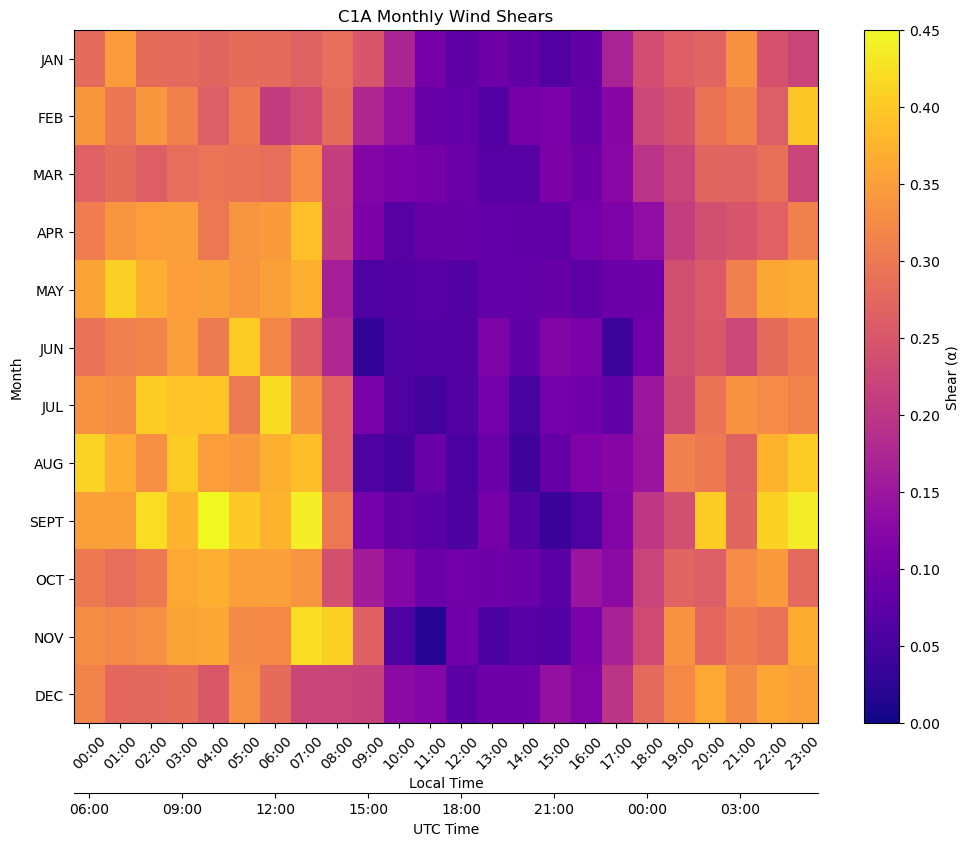

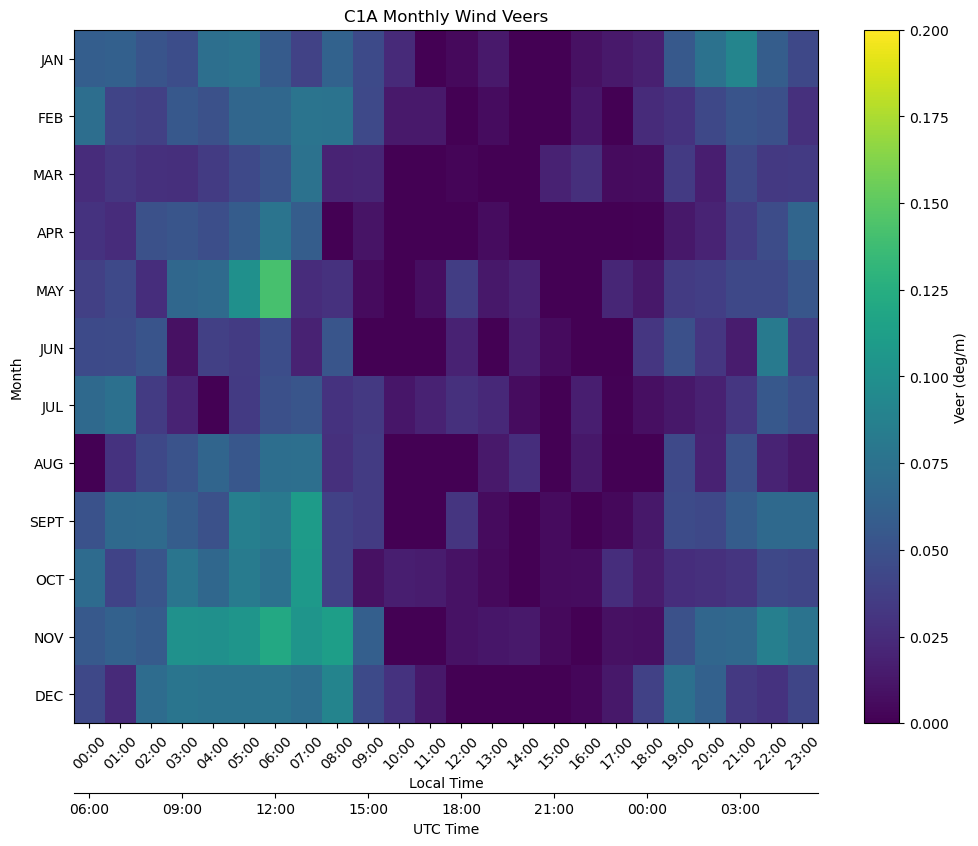

In [175]:
# === Local Time Labels for X-axis ===
time_labels = [f"{h:02d}:00" for h in range(24)]

# C1A Shear DataFrames
C1A_nov_shear_merge = C1A_avg_shear_202211.merge(C1A_avg_shear_202311, on = 'time_of_day', suffixes=('_1', '_2'))
C1A_nov_shear_merge['average_wind_shear'] = (C1A_nov_shear_merge['average_wind_shear_1'] + C1A_nov_shear_merge['average_wind_shear_2']) / 2

C1A_shear_dfs = [
    C1A_avg_shear_202301, C1A_avg_shear_202302, C1A_avg_shear_202303,
    C1A_avg_shear_202304, C1A_avg_shear_202305, C1A_avg_shear_202306,
    C1A_avg_shear_202307, C1A_avg_shear_202308, C1A_avg_shear_202309,
    C1A_avg_shear_202310, C1A_nov_shear_merge, C1A_avg_shear_202212
]

# C1A Veer DataFrames
C1A_nov_merge = C1A_avg_202211.merge(C1A_avg_202311, on = 'time_of_day', suffixes=('_1', '_2'))
C1A_nov_merge['average_wind_veer'] = (C1A_nov_merge['average_wind_veer_1'] + C1A_nov_merge['average_wind_veer_2']) / 2

C1A_veer_dfs = [
    C1A_avg_202301, C1A_avg_202302, C1A_avg_202303,
    C1A_avg_202304, C1A_avg_202305, C1A_avg_202306,
    C1A_avg_202307, C1A_avg_202308, C1A_avg_202309,
    C1A_avg_202310, C1A_nov_merge, C1A_avg_202212
]

# C1A Month Labels
C1A_labels = [
    'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEPT', 'OCT', 'NOV', 'DEC'
]

# === Generate and Plot All 4 Heatmaps ===
# C1A is UTC-6 (Oklahoma)
c1a_shear_matrix = prepare_heatmap_data(C1A_shear_dfs, value_col='average_wind_shear', utc_offset_hours=6)
c1a_veer_matrix  = prepare_heatmap_data(C1A_veer_dfs, value_col='average_wind_veer', utc_offset_hours=6)

# C1A — Shear
plot_heatmap(c1a_shear_matrix, C1A_labels,
             title="C1A Monthly Wind Shears", xlabel="Local Time", ylabel="Month",
             time_labels=time_labels, colorbar_label="Shear (α)", vmin=0, vmax=0.45, cmap='plasma',
             utc_offset_hours=6) # <-- ADD THIS

# C1A — Veer
plot_heatmap(c1a_veer_matrix, C1A_labels,
             title="C1A Monthly Wind Veers", xlabel="Local Time", ylabel="Month",
             time_labels=time_labels, colorbar_label="Veer (deg/m)", vmin=0, vmax=0.2, cmap='viridis',
             utc_offset_hours=6) # <-- ADD THIS